# Functions

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import confusion_matrix


# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Model Funcs

In [2]:
def plot_loss(losses, all_validation_loss=None, all_accuracies=None, already_saved_plot=0, str_model_name_datetime=None):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(10, 6))
    
        # Plot loss
    plt.plot(epochs, losses, label="Loss", marker='o', linestyle='-')
    
    # Plot accuracy
    if all_accuracies:
        plt.plot(epochs, all_accuracies, label="Accuracy", marker='s', linestyle='-')
    
    # Plot F1 score
    # plt.plot(epochs, all_f1_scores, label="F1 Score", marker='^', linestyle='-')
    if all_validation_loss:
        plt.plot(epochs, all_validation_loss, label='Validation Loss', marker='x')
    
    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Metrics Over Epochs')
    plt.legend()
    plt.grid(True)
    # Set x-axis ticks to natural numbers
    plt.xticks(range(1, len(losses) + 1))
    if not already_saved_plot and str_model_name_datetime is not None:
        plt.savefig(str_model_name_datetime+"/"+str_model_name_datetime+".jpg")
        already_saved_plot = 1
        
    plt.show()
    return already_saved_plot

In [3]:
def print_model_info(Model):
    # Count the number of parameters
    total_params = sum(p.numel() for p in Model.parameters())
    trainable_params = sum(p.numel() for p in Model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Estimate model size in bytes
    model_size_bytes = total_params * 4
    model_size_mb = model_size_bytes / (1024 ** 2)
    print(f"Estimated model size: {model_size_mb:.2f} MB")



def is_dataset_balanced(dataset):
    # Assuming y contains your labels
    class_distribution = np.bincount(dataset["label"])
    num_classes = len(class_distribution)
    
    # Print class distribution
    for class_idx, count in enumerate(class_distribution):
        print(f"Class {class_idx}: {count} samples")
    
    # Check if balanced
    min_samples = min(class_distribution)
    max_samples = max(class_distribution)
    if max_samples / min_samples < 2:
        print("The dataset is balanced.")
    else:
        print("The dataset is imbalanced.")
    
    
    # Assuming class_distribution contains the count of samples for each class
    class_labels = range(len(class_distribution))
    
    plt.figure(figsize=(5, 3))
    
    # Plot class distribution
    plt.bar(class_labels, class_distribution, color='skyblue')
    
    # Adding labels and title
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    
    plt.xticks(class_labels)
    plt.grid(axis='y')
    
    plt.show()


In [4]:
import os
from datetime import datetime

def save_the_model_tokenizer(model, tokenizer, base_dir, name=None):
    if name is None:
        current_datetime = datetime.now().strftime("%m.%d-%H.%M.%S")
        str_model_name_datetime = str(model.config.name_or_path + "--" + current_datetime)
    else:
        str_model_name_datetime = name
    
    # Create the full path
    full_path = os.path.join(base_dir, str_model_name_datetime)
    
    # Create the directory if it does not exist
    if not os.path.exists(full_path):
        os.makedirs(full_path)
    
    print(f"Saving model and tokenizer to: {full_path}")
    
    # Save model to a file
    model.save_pretrained(full_path)
    print("Model saved!")
    
    # Check the size of the saved model
    model_size_disk = sum(
        os.path.getsize(os.path.join(full_path, f)) for f in os.listdir(full_path)
    )
    
    model_size_disk_mb = model_size_disk / (1024 ** 2)
    print(f"Saved model size on disk: {model_size_disk_mb:.2f} MB\n\n")
    
    tokenizer.save_pretrained(full_path)
    print("Tokenizer saved!")
    
    return full_path



### Email Func

In [5]:
import smtplib
import ssl
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
import traceback

def send_email(subject, body):
    smtp_server = "REDACTED"
    port = 465  # For SSL
    username = "REDACTED"
    password = "REDACTED"  # Replace with your actual email account password
    sender_email = "REDACTED"
    receiver_email = "REDACTED"  # Replace with the recipient's email address

    # Create a multipart message and set headers
    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject

    # Add body to email
    message.attach(MIMEText(body, "plain"))

    # Secure SSL context
    context = ssl.create_default_context()

    try:
        # Connect to the server using SSL
        with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
            server.login(username, password)
            server.sendmail(sender_email, receiver_email, message.as_string())
            print("Notification email sent successfully!")
    except Exception as e:
        print(f"Error sending email: {e}")



def send_email_with_attachment(subject, body, attachment_path):
    smtp_server = "REDACTED"
    port = 465  # For SSL
    username = "REDACTED"
    password = "REDACTED"  # Replace with your actual email account password
    sender_email = "REDACTED"
    receiver_email = "REDACTED"

    # Create a multipart message and set headers
    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject

    # Add body to email
    message.attach(MIMEText(body, "plain"))

    # Open the file to be sent
    with open(attachment_path, "rb") as attachment:
        # Add file as application/octet-stream
        part = MIMEBase("application", "octet-stream")
        part.set_payload(attachment.read())

    # Encode file in ASCII characters to send by email
    encoders.encode_base64(part)

    # Add header as key/value pair to attachment part
    part.add_header(
        "Content-Disposition",
        f"attachment; filename= {attachment_path}",
    )

    # Add attachment to message and convert message to string
    message.attach(part)
    text = message.as_string()

    # Secure SSL context
    context = ssl.create_default_context()

    try:
        # Connect to the server using SSL
        with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
            server.login(username, password)
            server.sendmail(sender_email, receiver_email, text)
            print("Notification email with attachment sent successfully!")
    except Exception as e:
        print(f"Error sending email: {e}")



# Load the base Model

In [4]:
# from transformers import BertTokenizer, BertForSequenceClassification

# # Load pre-trained BERT model and tokenizer
# model_name = "bert-base-uncased"
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertForSequenceClassification.from_pretrained(model_name)


# # Move model to the GPU
# model.to(device)


In [6]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load pre-trained DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Move model to the GPU
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Model Info

In [7]:
print_model_info(model)

Total parameters: 66,955,010
Trainable parameters: 66,955,010
Estimated model size: 255.41 MB


# Dataset

### Step 2: Load the SST-2 Dataset


In [7]:
from datasets import load_dataset

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Check available splits
print("Dataset splits:", dataset.keys())


Dataset splits: dict_keys(['train', 'validation', 'test'])


In [8]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
# Convert the dataset to a pandas DataFrame
import pandas as pd
data_dicts = []
for example in dataset["train"]:
    data_dicts.append({k: v for k, v in example.items()})

df = pd.DataFrame(data_dicts)
df

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4
...,...,...,...
67344,a delightful comedy,1,67344
67345,"anguish , anger and frustration",0,67345
67346,"at achieving the modest , crowd-pleasing goals...",1,67346
67347,a patient viewer,1,67347


In [9]:
subset_train, train_half_as_test = train_test_split(df, test_size=0.5, stratify=df['label'], random_state=42)
subset_train

,sentence,label,idx
21952,a surprisingly ` solid ' achievement by direct...,1,21952
37991,"about this traditional thriller , moderately s...",0,37991
20580,a certain charm,1,20580
48176,epic,1,48176
65129,rightly,1,65129
...,...,...,...
11052,crime expertly,0,11052
63501,"it 's an exhilarating place to visit , this la...",1,63501
34580,is even lazier and far less enjoyable,0,34580
62738,whether this is art imitating life or life imi...,0,62738


In [10]:
train_half_as_test

,sentence,label,idx
15241,a 75-minute sample of puerile rubbish that is ...,0,15241
20659,to call the film ` refreshing,1,20659
61262,funny bone,1,61262
43898,the insightful writer/director,1,43898
42462,"a more annoying , though less angry",0,42462
...,...,...,...
28562,takes you by the face,1,28562
54832,create characters who are sweet and believable...,0,54832
31705,"is nearly incoherent , an excuse to get to the...",0,31705
16940,"a riveting profile of law enforcement , and a ...",1,16940


In [11]:
isinstance(subset_train, pd.DataFrame)

True

# Train

In [12]:
# Convert back to Huggingface Dataset
subset_train = Dataset.from_pandas(subset_train)

# Now tokenize the subset_train as before
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# Apply tokenization
tokenized_subset = subset_train.map(tokenize_function, batched=True)
tokenized_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map:   0%|          | 0/33674 [00:00<?, ? examples/s]

In [13]:
subset_train

Dataset({
    features: ['sentence', 'label', 'idx', '__index_level_0__'],
    num_rows: 33674
})

Class 0: 14890 samples
Class 1: 18784 samples
The dataset is balanced.


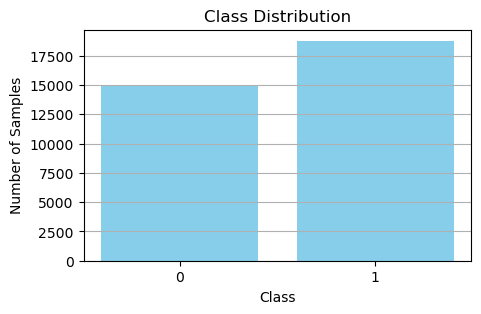

In [554]:
is_dataset_balanced(tokenized_subset)

In [15]:
# Number of samples in each split
print(f"Number of samples in train split: {len(dataset['train'])}")
print(f"Number of samples in validation split: {len(dataset['validation'])}")
print(f"Number of samples in test split: {len(dataset['test'])}")


Number of samples in train split: 67349
Number of samples in validation split: 872
Number of samples in test split: 1821


In [16]:
import sys

# Calculate memory size of a specific split
def calculate_dataset_size(split):
    total_size = sum(sys.getsizeof(example) for example in split)
    return total_size

# Calculate sizes for train, validation, and test splits
train_size = calculate_dataset_size(dataset["train"])
validation_size = calculate_dataset_size(dataset["validation"])
test_size = calculate_dataset_size(dataset["test"])

# Convert sizes to MB
train_size_mb = train_size / (1024 ** 2)
validation_size_mb = validation_size / (1024 ** 2)
test_size_mb = test_size / (1024 ** 2)

print(f"Train split size: {train_size_mb:.2f} MB")
print(f"Validation split size: {validation_size_mb:.2f} MB")
print(f"Test split size: {test_size_mb:.2f} MB")


Train split size: 11.82 MB
Validation split size: 0.15 MB
Test split size: 0.32 MB


### Step 3: Prepare the Dataset [Tokenizing]

In [17]:
# # Tokenize the dataset
# def tokenize_function(examples):
#     return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# # Apply tokenization to the dataset
# tokenized_dataset = dataset.map(tokenize_function, batched=True)

# # Prepare input tensors for training
# train_dataset = tokenized_dataset["train"]
# train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# # Example of fetching input tensors and labels
# input_ids = train_dataset[:]["input_ids"]
# attention_mask = train_dataset[:]["attention_mask"]
# labels = train_dataset[:]["label"]

# # Print dataset sample sizes
# print(f"Train dataset size: {len(train_dataset)}")


## Step 4: Fine-Tune the BERT Model

In [18]:
# Apply tokenization
tokenized_validation = dataset['validation'].map(tokenize_function, batched=True)
tokenized_validation.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [19]:
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
# Store losses for plotting
losses = []
all_accuracies = []
all_f1_scores = []
all_recalls = []
all_precisions = []
all_validation_loss = []
num_epochs = 3
# Define number of accumulation steps
accumulation_steps = 4
batch_size = 64
# Create data loader
train_dataloader = DataLoader(tokenized_subset, batch_size=batch_size, shuffle=True)

METRICS_AVERAGE_METHOD=["None", "micro", "macro", "weighted"]
MAM = 2

# Initialize optimizer and scaler (if using mixed precision)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scaler = GradScaler()

# Record start time
start_time = time.time()


# data validation 
validation_dataloader = DataLoader(tokenized_validation, batch_size=batch_size, shuffle=False)


# model.train()
for epoch in range(num_epochs):  # Example of two epochs
    epoch_loss = 0
    optimizer.zero_grad()

    # Initialize metric accumulators
    all_preds = []
    all_labels = []
    
    # Initialize the progress bar
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", mininterval=5)

    model.train()
    for i, batch in enumerate(progress_bar):
        # Move batch to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass with mixed precision (if applicable)
        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps  # Normalize loss

        # Backpropagate and accumulate gradients
        scaler.scale(loss).backward() if scaler else loss.backward()

        # Update weights after accumulating enough gradients
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer) if scaler else optimizer.step()
            scaler.update() if scaler else None
            optimizer.zero_grad()

        # Track batch loss and update progress bar
        batch_loss = loss.item() * accumulation_steps
        epoch_loss += batch_loss
        progress_bar.set_postfix(loss=batch_loss)

        # Accumulate predictions and labels
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())



    # VALIDATION ------------------------------------------------------------------
    model.eval()  # Set the model to evaluation mode for validation
    with torch.no_grad():  # Turn off gradients for validation
        validation_loss = 0
        validation_preds = []
        validation_labels = []
        
        for batch in tqdm(validation_dataloader, desc="Validating"):
            # Validation code similar to training but without backpropagation
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            
            validation_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            validation_preds.extend(preds)
            validation_labels.extend(labels.cpu().numpy())
        
        avg_validation_loss = validation_loss / len(validation_dataloader)
        all_validation_loss.append(avg_validation_loss)
        # all_validation_loss.append(validation_loss)
        # Calculate validation metrics
        valid_accuracy = accuracy_score(validation_labels, validation_preds)
        valid_f1 = f1_score(validation_labels, validation_preds, average=METRICS_AVERAGE_METHOD[MAM])
        print(f"Validation ----\n \
        Epoch {epoch + 1}, Loss: {avg_validation_loss:.4f}, Accuracy: {valid_accuracy:.4f}, F1: {valid_f1:.4f}\n\n-----\n")

    # END VALIDATION -------------------------------------------
    
    # Calculate metrics for the epoch
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    epoch_accuracy = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    epoch_precision = precision_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    epoch_recall = recall_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])  # Calculate recall for each class

    # # Print precision
    # print(f"Precision = {precision:.4f}")
    losses.append(avg_epoch_loss)
    all_accuracies.append(epoch_accuracy)
    all_f1_scores.append(epoch_f1)
    all_precisions.append(epoch_precision)
    all_recalls.append(epoch_recall)
    # Print metrics
    print(f"Epoch {epoch + 1}, Loss: {avg_epoch_loss:.4f}, \
    Accuracy: {epoch_accuracy:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1: {epoch_f1:.4f}")
# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds")

Epoch 1:   0%|          | 0/527 [00:00<?, ?it/s]

Validating:   0%|          | 0/14 [00:00<?, ?it/s]

Validation ----
         Epoch 1, Loss: 0.2590, Accuracy: 0.8922, F1: 0.8922

-----

Epoch 1, Loss: 0.3438,     Accuracy: 0.8435, Precision: 0.8446, Recall: 0.8372, F1: 0.8398


Epoch 2:   0%|          | 0/527 [00:00<?, ?it/s]

Validating:   0%|          | 0/14 [00:00<?, ?it/s]

Validation ----
         Epoch 2, Loss: 0.2750, Accuracy: 0.8933, F1: 0.8933

-----

Epoch 2, Loss: 0.1848,     Accuracy: 0.9300, Precision: 0.9286, Recall: 0.9298, F1: 0.9292


Epoch 3:   0%|          | 0/527 [00:00<?, ?it/s]

Validating:   0%|          | 0/14 [00:00<?, ?it/s]

Validation ----
         Epoch 3, Loss: 0.2759, Accuracy: 0.9071, F1: 0.9071

-----

Epoch 3, Loss: 0.1304,     Accuracy: 0.9543, Precision: 0.9533, Recall: 0.9541, F1: 0.9537
Training completed in 509.17 seconds


## Save the model and tokenizer

In [20]:
!pwd

/home/REDACTED/bert-distillation-backdoor/jupyter/distillation


In [611]:
import os
from datetime import datetime
def save_the_model_tokenizer(model, tokenizer, name=None):
    if name is None:
        current_datetime = datetime.now().strftime("%m.%d-%H.%M.%S")
        str_model_name_datetime = str(model.config.name_or_path +"--"+ current_datetime)
    else: 
        str_model_name_datetime = name
    print(str_model_name_datetime)
    
    # Save model to a file
    model.save_pretrained(str_model_name_datetime)
    print("model saved!")
    
    # Check the size of the saved model
    model_size_disk = sum(
        os.path.getsize(os.path.join(str_model_name_datetime, f)) for f in os.listdir(str_model_name_datetime)
    )
    #    os.path.getsize(os.path.join("bert_model", f)) for f in os.listdir(str_model_name_datetime)
    
    model_size_disk_mb = model_size_disk / (1024 ** 2)
    print(f"Saved model size on disk: {model_size_disk_mb:.2f} MB\n\n")
    
    print(tokenizer.save_pretrained(str_model_name_datetime))
    return str_model_name_datetime

In [44]:
import os
from datetime import datetime

def save_the_model_tokenizer(model, tokenizer, base_dir, name=None):
    if name is None:
        current_datetime = datetime.now().strftime("%m.%d-%H.%M.%S")
        str_model_name_datetime = str(model.config.name_or_path + "--" + current_datetime)
    else:
        str_model_name_datetime = name
    
    # Create the full path
    full_path = os.path.join(base_dir, str_model_name_datetime)
    
    # Create the directory if it does not exist
    if not os.path.exists(full_path):
        os.makedirs(full_path)
    
    print(f"Saving model and tokenizer to: {full_path}")
    
    # Save model to a file
    model.save_pretrained(full_path)
    print("Model saved!")
    
    # Check the size of the saved model
    model_size_disk = sum(
        os.path.getsize(os.path.join(full_path, f)) for f in os.listdir(full_path)
    )
    
    model_size_disk_mb = model_size_disk / (1024 ** 2)
    print(f"Saved model size on disk: {model_size_disk_mb:.2f} MB\n\n")
    
    tokenizer.save_pretrained(full_path)
    print("Tokenizer saved!")
    
    return full_path



In [25]:
already_saved_plot = 0

In [26]:
str_model_name_datetime = save_the_model_tokenizer(model, tokenizer)


distilbert-base-uncased--05.25-23.58.46
model saved!
Saved model size on disk: 255.43 MB


('distilbert-base-uncased--05.25-23.58.46/tokenizer_config.json', 'distilbert-base-uncased--05.25-23.58.46/special_tokens_map.json', 'distilbert-base-uncased--05.25-23.58.46/vocab.txt', 'distilbert-base-uncased--05.25-23.58.46/added_tokens.json')


In [28]:
!pwd

/home/REDACTED/bert-distillation-backdoor/jupyter/distillation


Confusion Matrix:
[[14187   703]
 [  837 17947]]


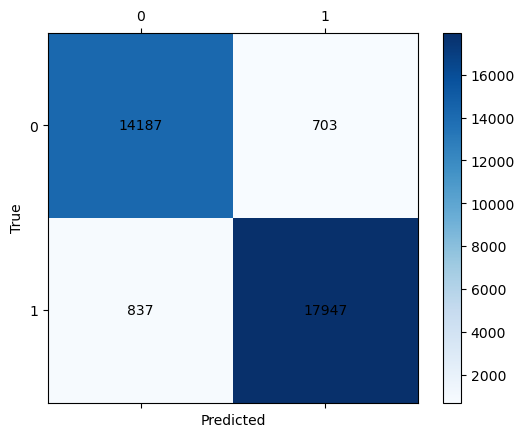

In [27]:

# Assuming all_labels and all_preds contain the true labels and predicted labels for each sample
conf_matrix = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(conf_matrix)
# Plotting the confusion matrix as a table
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
fig.colorbar(cax)

# Add labels
plt.xlabel('Predicted')
plt.ylabel('True')

# Add annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center')

# Add class labels
plt.xticks(range(conf_matrix.shape[1]))
plt.yticks(range(conf_matrix.shape[0]))

plt.show()


In [28]:
losses

[0.34376804471242134, 0.18484378842181, 0.130420711619578]

In [37]:
# from torch.utils.data import DataLoader
# import time
# # Create optimizer
# optimizer = AdamW(model.parameters(), lr=5e-5)

# # Create data loader
# # train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)


# # Store losses for plotting
# losses = []

# # Record start time
# start_time = time.time()

# # Train the model
# model.train()
# for epoch in range(2):  # Example of two epochs
#     epoch_loss = 0
#     for batch in train_dataloader:
#         # Move batch to GPU
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['label'].to(device)  # Note that the correct key should be 'labels'

#         optimizer.zero_grad()
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()

#     avg_epoch_loss = epoch_loss / len(train_dataloader)
#     losses.append(avg_epoch_loss)
#     print(f"Epoch {epoch + 1}, Loss: {avg_epoch_loss:.4f}")

# # Record end time
# end_time = time.time()

# # Calculate elapsed time
# elapsed_time = end_time - start_time
# print(f"Training completed in {elapsed_time:.2f} seconds")

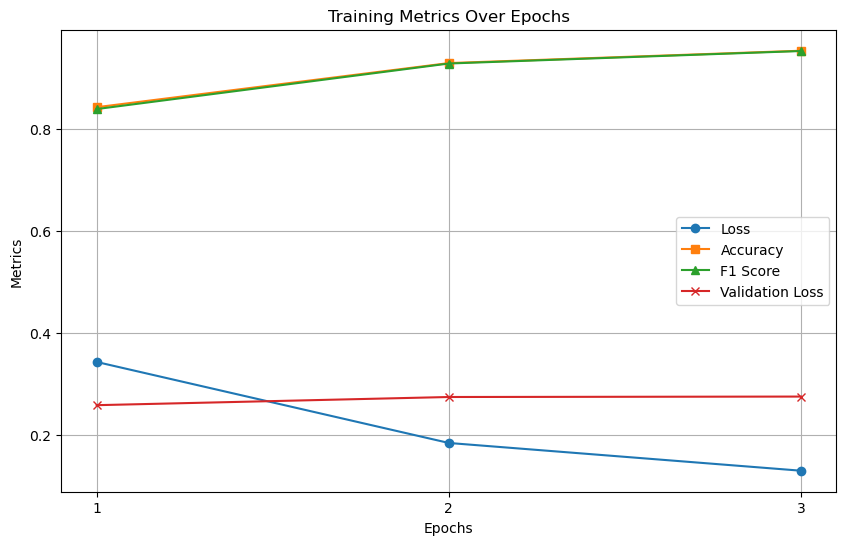

In [29]:
import matplotlib.pyplot as plt

# Assuming losses, accuracies, and f1_scores contain the values for each epoch
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(10, 6))

# Plot loss
plt.plot(epochs, losses, label="Loss", marker='o', linestyle='-')

# Plot accuracy
plt.plot(epochs, all_accuracies, label="Accuracy", marker='s', linestyle='-')

# Plot F1 score
plt.plot(epochs, all_f1_scores, label="F1 Score", marker='^', linestyle='-')

plt.plot(epochs, all_validation_loss, label='Validation Loss', marker='x')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.grid(True)
# Set x-axis ticks to natural numbers
plt.xticks(range(1, len(losses) + 1))
if not already_saved_plot:
    plt.savefig(str_model_name_datetime+"/"+str_model_name_datetime+".jpg")
    already_saved_plot = 1
    
plt.show()


# Distillation

## Define the student

In [14]:
from transformers import DistilBertConfig, DistilBertForSequenceClassification

# Define a smaller model configuration
student_config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
student_config.num_hidden_layers = 3  # Reduce the number of layers

# Create the student model with the new configuration
student_model = DistilBertForSequenceClassification(student_config)


In [31]:
student_config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 3,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.40.1",
  "vocab_size": 30522
}

In [15]:
print_model_info(student_model)

Total parameters: 45,691,394
Trainable parameters: 45,691,394
Estimated model size: 174.30 MB


## Copy Layers from the Larger Model

In [33]:
student_model.distilbert

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-2): 3 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [16]:
# Copy embeddings
student_model.distilbert.embeddings = model.distilbert.embeddings

# Copy selected transformer layers
for student_layer, teacher_layer in zip(student_model.distilbert.transformer.layer, model.distilbert.transformer.layer[:student_config.num_hidden_layers]):
    student_layer.load_state_dict(teacher_layer.state_dict())


In [14]:
batch_size =16
# train_dataloader = DataLoader(tokenized_subset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(tokenized_validation, batch_size=batch_size, shuffle=False)

In [361]:
validation_dataloader.dataset[0]

{'label': tensor(1),
 'input_ids': tensor([  101,  2009,  1005,  1055,  1037, 11951,  1998,  2411, 12473,  4990,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

In [351]:
len(validation_dataloader)

55

In [40]:
student_model.device

device(type='cuda', index=0)

In [41]:
model.device

device(type='cuda', index=0)

In [11]:
batch_size = 64
train_second_subset_dataloader = DataLoader(tokenized_train_second_subset, batch_size=batch_size, shuffle=False)

### Distilling

In [15]:
from torch.nn import KLDivLoss, CrossEntropyLoss
import torch
from tqdm.notebook import tqdm

# Ensure the student model and data loaders are defined
# Example placeholders:
student_model = student_base_model
# model = ...
train_dataloader_temp = train_second_subset_dataloader
# validation_dataloader = ...
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alpha = 0.6
all_loss_distil, all_val_loss_distil = [], []

# Move models to the device
student_model.to(device)
model.to(device)

# Loss functions
distillation_loss_function = KLDivLoss(reduction='batchmean')
task_loss_function = CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=5e-5)
temperature = 2.0

email_intervals = 8

num_epochs = 30

try:
    for epoch in range(num_epochs):
        if epoch % (num_epochs // email_intervals) == 0 or epoch == num_epochs:
            progress = (epoch / num_epochs) * 100
            send_email("Training Progress Update", f"Training is {progress:.2f}% complete. Epoch = {epoch}")

        # Training phase
        student_model.train()
        epoch_train_loss = 0
        for batch in tqdm(train_dataloader_temp, desc=f"Training Epoch {epoch + 1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
    
            with torch.no_grad():
                teacher_logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
    
            student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
            student_logits = student_outputs.logits
    
            distillation_loss = distillation_loss_function(
                torch.log_softmax(student_logits / temperature, dim=-1),
                torch.softmax(teacher_logits / temperature, dim=-1)
            )
    
            # Optional: combine with classic loss, e.g., cross-entropy
            # -------------------------------------------------------------------------------------------------
            # loss = distillation_loss  # This is where I can modify according to my loss combination strategy
    
            task_loss = task_loss_function(student_logits, labels)
            loss = alpha * distillation_loss + (1 - alpha) * task_loss
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            epoch_train_loss += loss.item()
    
        # Validation phase
        student_model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(validation_dataloader, desc=f"Validation Epoch {epoch + 1}"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
    
                student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
                student_logits = student_outputs.logits
                task_loss = task_loss_function(student_logits, labels)
                
                epoch_val_loss += task_loss.item()
    
        # Log the average losses
        train_loss = epoch_train_loss / len(train_dataloader_temp)
        val_loss = epoch_val_loss / len(validation_dataloader)
        all_loss_distil.append(train_loss)
        all_val_loss_distil.append(val_loss)
        print(f"Epoch {epoch + 1}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")
    
        send_email("The epoch is Done!", f"Epoch {epoch + 1}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")

except Exception as e:
    error_message = f"An error occurred during training: {traceback.format_exc()}"
    send_email("Training Error", error_message)








Notification email sent successfully!


Training Epoch 1:   0%|          | 0/527 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1: Training Loss = 0.1500, Validation Loss = 0.3966
Notification email sent successfully!


Training Epoch 2:   0%|          | 0/527 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2: Training Loss = 0.1384, Validation Loss = 0.3659
Notification email sent successfully!


Training Epoch 3:   0%|          | 0/527 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3: Training Loss = 0.1332, Validation Loss = 0.3673
Notification email sent successfully!
Notification email sent successfully!


Training Epoch 4:   0%|          | 0/527 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4: Training Loss = 0.1298, Validation Loss = 0.3646
Notification email sent successfully!


Training Epoch 5:   0%|          | 0/527 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 5: Training Loss = 0.1288, Validation Loss = 0.3565
Notification email sent successfully!


Training Epoch 6:   0%|          | 0/527 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 6: Training Loss = 0.1272, Validation Loss = 0.3849
Notification email sent successfully!
Notification email sent successfully!


Training Epoch 7:   0%|          | 0/527 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 7: Training Loss = 0.1266, Validation Loss = 0.3781
Notification email sent successfully!


Training Epoch 8:   0%|          | 0/527 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 8: Training Loss = 0.1255, Validation Loss = 0.3732
Notification email sent successfully!


Training Epoch 9:   0%|          | 0/527 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 9: Training Loss = 0.1250, Validation Loss = 0.3605
Notification email sent successfully!
Notification email sent successfully!


Training Epoch 10:   0%|          | 0/527 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [16]:
error_message

'An error occurred during training: Traceback (most recent call last):\n  File "/tmp/ipykernel_263358/1400429734.py", line 74, in <module>\n    for batch in tqdm(validation_dataloader, desc=f"Validation Epoch {epoch + 1}"):\n                      ^^^^^^^^^^^^^^^^^^^^^\nNameError: name \'validation_dataloader\' is not defined\n'

In [17]:
all_loss_distil

[0.15001649152225968,
 0.13836808458847158,
 0.1331538653860056,
 0.12977705835108513,
 0.1287506025220909,
 0.12722017811134145,
 0.1265982819378263,
 0.12546015498307897,
 0.12496664817577521,
 0.12445750197773867,
 0.12480265726344182,
 0.12399106940689304,
 0.12339015141044668,
 0.12342499024049154,
 0.12351676584194915,
 0.12331316440562369,
 0.12261252734364776,
 0.12268417915311665,
 0.1227707834719933,
 0.12248161539746416,
 0.12260088822194702,
 0.12221880419713496,
 0.12202814441930637,
 0.12208589386951313,
 0.12221555332644389,
 0.12179991274902445,
 0.12180280411152958,
 0.12203315832074273,
 0.12186977168301251,
 0.12190654099100681]

In [18]:
all_val_loss_distil

[0.3966258252208883,
 0.3659220673821189,
 0.3672557619484988,
 0.36460328671065245,
 0.3564703445542942,
 0.3849052805792202,
 0.37811282737688584,
 0.3732163954864849,
 0.36047968647696754,
 0.37304571081291543,
 0.39334093169732526,
 0.37253872589631515,
 0.38406389193101365,
 0.38089397658001295,
 0.37766145738688384,
 0.3779750255021182,
 0.38770885304971175,
 0.385344196991487,
 0.38219392164187,
 0.3788431858474558,
 0.39921090765432876,
 0.3876283667304299,
 0.40245043228973043,
 0.3943321485411037,
 0.3899824421514164,
 0.386716538938609,
 0.39062363532456484,
 0.39348861195824364,
 0.385749089717865,
 0.4023913204669952]

In [25]:
distillation_results = {
    "all_loss_distil" : all_loss_distil,
    "all_val_loss_distil" : all_val_loss_distil
}

#### Saving

In [22]:
import os
import pickle
from datetime import datetime

current_datetime = datetime.now().strftime("%m.%d-%H.%M.%S")
directory_name = f"Distilled_{current_datetime}"

# Create the directory if it doesn't exist
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

print(f"A Directory named  '{directory_name}' has been made.")


A Directory named  'Distilled_07.05-00.49.40' has been made.


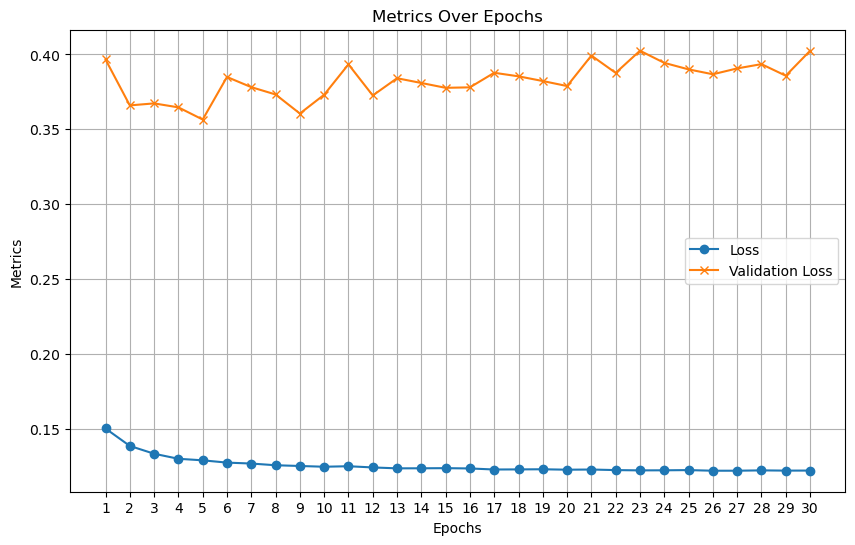

1

In [23]:
plot_loss(all_loss_distil, all_val_loss_distil,str_model_name_datetime=directory_name)

In [26]:
distillation_results_path = os.path.join(directory_name, 'distillation_results.pkl')

# Save the all_results list to a file
with open(distillation_results_path, 'wb') as file:
    pickle.dump(distillation_results, file)

print(f"all_results has been saved to {distillation_results_path}")



# Save the teacher and student models and tokenizers
save_the_model_tokenizer(student_model, tokenizer, directory_name, f"student_model_distilled")

all_results has been saved to Distilled_07.05-00.49.40/distillation_results.pkl
Saving model and tokenizer to: Distilled_07.05-00.49.40/student_model_distilled
Model saved!
Saved model size on disk: 174.31 MB


Tokenizer saved!


'Distilled_07.05-00.49.40/student_model_distilled'

#### Distill without train loss and validation

In [62]:
from torch.nn import KLDivLoss
import torch

# Loss function for distillation
distillation_loss_function = KLDivLoss(reduction='batchmean', log_target=True)

# Set the student model to training mode and teacher model to evaluation mode
student_model.to(device)
student_model.train()
model.to(device)
model.eval()

# Prepare optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)

# Training loop with tqdm progress bar
for epoch in range(7):
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Teacher model outputs
        with torch.no_grad():
            teacher_logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

        # Student model outputs
        student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        student_logits = student_outputs.logits

        # Distillation loss calculation
        distillation_loss = distillation_loss_function(
            torch.log_softmax(student_logits / 2, dim=-1),
            torch.softmax(teacher_logits / 2, dim=-1)
        )

        # Optional: combine with classic loss, e.g., cross-entropy
        # -------------------------------------------------------------------------------------------------
        loss = distillation_loss  # This is where I can modify according to my loss combination strategy

        
        # Loss update
        optimizer.zero_grad()
        distillation_loss.backward()
        optimizer.step()

        # Update the progress bar
        epoch_loss += distillation_loss.item()
        progress_bar.set_postfix({'loss': distillation_loss.item()})

    # Close the progress bar and display results
    progress_bar.close()
    print(f"Epoch {epoch + 1} finished with average loss: {epoch_loss / len(train_dataloader):.4f}")


Epoch 1:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 1 finished with average loss: 4.5853


Epoch 2:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 2 finished with average loss: 4.5833


Epoch 3:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 3 finished with average loss: 4.5841


Epoch 4:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 4 finished with average loss: 4.5834


Epoch 5:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 5 finished with average loss: 4.5816


Epoch 6:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 6 finished with average loss: 4.5824


Epoch 7:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 7 finished with average loss: 4.5809


### fine tune it

In [ ]:
# Move the smaller model to the GPU
small_bert_model.to(device)

# Train the smaller model
small_bert_model.train()
small_model_losses = []

for epoch in range(2):  # Example of two epochs
    epoch_loss = 0
    for batch in train_dataloader:
        # Move batch to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = small_bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    small_model_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_epoch_loss:.4f}")


### Load the distilled student model

In [12]:
model_path = 'Distilled_07.05-00.49.40/student_model_distilled'
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Load pre-trained BERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
student_model = DistilBertForSequenceClassification.from_pretrained(model_path)


# Move model to the GPU
student_model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-2): 3 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

# Evaluate the model

In [ ]:
str_model_name_datetime

In [ ]:
import torch
from transformers import BertForSequenceClassification

# Load the trained model
model = DistilBertForSequenceClassification.from_pretrained(str_model_name_datetime)
model.eval()  # Set to evaluation mode


In [ ]:
str_model_name_datetime

In [ ]:
# from sklearn.model_selection import train_test_split
# from datasets import load_dataset, Dataset
# # Convert the dataset to a pandas DataFrame
# import pandas as pd
# test_dicts = []
# for example in dataset["validation"]:
#     test_dicts.append({k: v for k, v in example.items()})
# train_half_as_test
# test_df = pd.DataFrame(test_dicts)
test_data = Dataset.from_pandas(train_half_as_test)

In [ ]:
test_data

In [ ]:
# test_data[0]

In [568]:
from sklearn.model_selection import StratifiedKFold
def evaluate_model(model, tokenizer, dataset:Dataset):
    model.to(device)

    
    sentences = [entry['sentence'] for entry in dataset]
    labels = [entry['label'] for entry in dataset]
    X = np.array(sentences)
    y = np.array(labels)



    # Set up stratified cross-validation
    n_splits = 2  # Number of folds
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    from sklearn.metrics import accuracy_score, f1_score, recall_score
    
    # Initialize metric accumulators
    all_accuracies = []
    all_f1_scores = []
    all_recalls = []
    all_precisions = []
    
    
    METRICS_AVERAGE_METHOD=["None", "micro", "macro", "weighted"]
    MAM = 2
    
    
    # Perform evaluation for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Evaluating fold {fold_idx + 1}/{n_splits}")
    
        val_texts = X[val_idx]
        val_labels = torch.tensor(y[val_idx]).to(device)  # Move labels to CUDA
    
        # tokenizer = DistilBertTokenizer.from_pretrained(str_model_name_datetime)
        val_encodings = tokenizer(val_texts.tolist(), padding="max_length", truncation=True, return_tensors="pt")
        val_encodings = {key: tensor.to(device) for key, tensor in val_encodings.items()}  # Move tensors to CUDA
    
        val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)
    
        all_preds, all_labels = [], []
        with torch.no_grad():
            for input_ids, attention_mask, labels in val_dataloader:
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move input tensors to CUDA
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(preds.cpu().numpy())  # Move predictions back to CPU
                all_labels.extend(labels.cpu().numpy())  # Move labels back to CPU
    
        # Calculate and store metrics
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
        recall = recall_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])  # Calculate recall for each class
        precision = precision_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
        all_accuracies.append(acc)
        all_f1_scores.append(f1)
        all_recalls.append(recall)
        all_precisions.append(precision)
    
    
        
        print(f"Fold {fold_idx + 1}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}, Recall = {recall}")
    
    # Summary of results
    print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")
    print(f"Average F1 Score: {np.mean(all_f1_scores):.4f}")
    print(f"Average Recall Score: {np.mean(all_recalls):.4f}")
    return all_accuracies, all_f1_scores, all_recalls, all_precisions

In [ ]:
test = evaluate_model(student_model, tokenizer, test_data)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

model.to(device)

# Set up stratified cross-validation
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

from sklearn.metrics import accuracy_score, f1_score, recall_score

# Initialize metric accumulators
all_accuracies = []
all_f1_scores = []
all_recalls = []
all_precisions = []


METRICS_AVERAGE_METHOD=["None", "micro", "macro", "weighted"]
MAM = 2


# Perform evaluation for each fold
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Evaluating fold {fold_idx + 1}/{n_splits}")

    val_texts = X[val_idx]
    val_labels = torch.tensor(y[val_idx]).to(device)  # Move labels to CUDA

    tokenizer = DistilBertTokenizer.from_pretrained(str_model_name_datetime)
    val_encodings = tokenizer(val_texts.tolist(), padding="max_length", truncation=True, return_tensors="pt")
    val_encodings = {key: tensor.to(device) for key, tensor in val_encodings.items()}  # Move tensors to CUDA

    val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move input tensors to CUDA
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())  # Move predictions back to CPU
            all_labels.extend(labels.cpu().numpy())  # Move labels back to CPU

    # Calculate and store metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    recall = recall_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])  # Calculate recall for each class
    precision = precision_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    all_accuracies.append(acc)
    all_f1_scores.append(f1)
    all_recalls.append(recall)
    all_precisions.append(precision)


    
    print(f"Fold {fold_idx + 1}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}, Recall = {recall}")

# Summary of results
print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(all_f1_scores):.4f}")
print(f"Average Recall Score: {np.mean(all_recalls):.4f}")


In [ ]:
def calculate_f1(precision, recall):
    """
    Calculate the F1 score for given precision and recall values.
    """
    if precision + recall == 0:
        return 0
    else:
        return 2 * (precision * recall) / (precision + recall)

In [ ]:
# Calculate F1 score for each pair of precision and recall values
f1_scores = [calculate_f1(p, r) for p, r in zip(all_precisions, all_recalls)]

# Print the F1 scores
print("F1 scores:", f1_scores)
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")

In [ ]:
all_recalls


In [ ]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot accuracy
ax.plot(range(1, n_splits + 1), all_accuracies, marker='o', label='Accuracy')

# Plot F1 score
ax.plot(range(1, n_splits + 1), all_f1_scores, marker='o', label='F1 Score')

# Plot recall for each class (assuming binary classification)
# for class_idx in range(len(all_recalls[0])):
#     recalls = [recall[class_idx] for recall in all_recalls]
ax.plot(range(1, n_splits + 1), all_recalls, marker='o', label=f'Recall Class {class_idx}')

ax.set_xlabel('Fold')
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics')
ax.legend()
plt.xticks(range(1, n_splits + 1))
plt.grid(True)

plt.savefig(str_model_name_datetime+"/Evaluation"+str_model_name_datetime+".jpg")

plt.show()


In [ ]:

test_data


### Evaluate the model on test data to report the loss to evaluate the training process

In [ ]:
# Apply tokenization
test_data = test_data.map(tokenize_function, batched=True)
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


### Test Loss to compare the training

In [577]:
def eval_model_loss(model, dataloader:DataLoader):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        test_preds = []
        test_labels = []
        
        for batch in tqdm(dataloader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
    
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            
            test_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_labels.extend(labels.cpu().numpy())
    
        test_loss /= len(dataloader)
        test_accuracy = accuracy_score(test_labels, test_preds)
        test_f1 = f1_score(test_labels, test_preds, average=METRICS_AVERAGE_METHOD[MAM])
        print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}")

In [ ]:
model.eval()
with torch.no_grad():
    test_loss = 0
    test_preds = []
    test_labels = []
    
    for batch in tqdm(test_data_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        
        test_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_data_loader)
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average=METRICS_AVERAGE_METHOD[MAM])
    print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}")

### Test loss and evaluation in one pipeline

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

model.to(device)

# Set up stratified cross-validation
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

from sklearn.metrics import accuracy_score, f1_score, recall_score

# Initialize metric accumulators
all_accuracies = []
all_f1_scores = []
all_recalls = []
all_precisions = []
all_test_losses = []

METRICS_AVERAGE_METHOD=["None", "micro", "macro", "weighted"]
MAM = 2


# Perform evaluation for each fold
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Evaluating fold {fold_idx + 1}/{n_splits}")
    
    
    
    val_texts = X[val_idx]
    val_labels = torch.tensor(y[val_idx]).to(device)  # Move labels to CUDA

    tokenizer = DistilBertTokenizer.from_pretrained(str_model_name_datetime)
    val_encodings = tokenizer(val_texts.tolist(), padding="max_length", truncation=True, return_tensors="pt")
    val_encodings = {key: tensor.to(device) for key, tensor in val_encodings.items()}  # Move tensors to CUDA

    val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

    all_preds, all_labels, all_losses = [], [], []
    test_loss = 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move input tensors to CUDA
            # outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            test_loss += loss.item()
            # test_loss += outputs.loss.item()            
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())  # Move predictions back to CPU
            all_labels.extend(labels.cpu().numpy())  # Move labels back to CPU

    # Calculate and store metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    recall = recall_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])  # Calculate recall for each class
    precision = precision_score(all_labels, all_preds, average=METRICS_AVERAGE_METHOD[MAM])
    all_accuracies.append(acc)
    all_f1_scores.append(f1)
    all_recalls.append(recall)
    all_precisions.append(precision)
    test_loss /= len(test_data_loader)
    all_test_losses.append(test_loss)    
    print(f"Fold {fold_idx + 1}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}, Recall = {recall}, Test Loss = {test_loss}")

# Summary of results
print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(all_f1_scores):.4f}")
print(f"Average Recall Score: {np.mean(all_recalls):.4f}")


# Optimizable Trigger 

## Trigger alone

In [46]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.40.1",
  "vocab_size": 30522
}

### Trigger functions

In [239]:
def discretize_embeddings(trigger_embedding, all_embeddings_weights):
    """
    Finds the nearest token indices for each embedding in trigger_embedding.
    
    Args:
    - trigger_embedding: A tensor of shape (num_triggers, embedding_dim), where embedding_dim should be 768 for DistilBERT.
    - all_embeddings: The embeddings matrix from the model, typically model.embeddings.weight for models like BERT or DistilBERT.

    Returns:
    - Tensor of indices with shape (num_triggers,), each index corresponding to the nearest embedding in the vocabulary.
    """
    # Ensure trigger_embedding is correctly sized, e.g., (num_triggers, 768)
    # Calculate distances from each trigger embedding to all model embeddings
    distances = torch.cdist(trigger_embedding.unsqueeze(0), all_embeddings_weights.unsqueeze(0))
    # Find the indices of the closest embeddings
    return torch.argmin(distances, dim=-1)

def convert_trigger_embedding_to_list_of_words(trigger_embedding, all_embeddings_weights):
    distances = torch.cdist(trigger_embedding.unsqueeze(0), all_embeddings_weights.unsqueeze(0))
    discrete_tokens = torch.argmin(distances, dim=-1)
    discrete_tokens_flat = discrete_tokens.squeeze().tolist()
    return tokenizer.convert_ids_to_tokens(discrete_tokens_flat)


# similarity check

def similarity_of_two_tokens(first_word, second_word):
    # Example: Compare embeddings for two words
    token_id_1 = tokenizer.convert_tokens_to_ids(first_word)
    token_id_2 = tokenizer.convert_tokens_to_ids(second_word)
    # Retrieve embeddings for these tokens
    embedding_1 = all_embeddings[token_id_1]
    embedding_2 = all_embeddings[token_id_2]
    
    # Compute cosine similarity between these two embeddings
    cosine_similarity = torch.nn.functional.cosine_similarity(embedding_1, embedding_2, dim=0)
    return cosine_similarity.item()

In [408]:
# Functions tests

print(f"Triggers tokens ids: {discretize_embeddings(trigger_embedding, all_embeddings)}")
print(f"Cosine similarity between 'hello' and 'world': {similarity_of_two_tokens("hello", 'world')}")


Triggers tokens ids: torch.Size([1, 2])
Cosine similarity between 'hello' and 'world': 0.21547207236289978


In [227]:
# DistilBERT

# Get embeddings from the model
embeddings = model.get_input_embeddings()

# 'all_embeddings' contains the embedding matrix (embeddings weight)
all_embeddings = embeddings.weight  # This tensor has shape [vocab_size, embedding_dim]

In [156]:
# Access the embedding size
embedding_size = model.distilbert.embeddings.word_embeddings.embedding_dim

print("Embedding size:", embedding_size)  # This should print 768


Embedding size: 768


In [228]:
embeddings.embedding_dim

768

### Tokenizing examples

In [446]:
import torch
from torch import nn
from torch.optim import Adam

# Initial trigger as embeddings directly
n_tokens = 4
trigger_embedding = nn.Parameter(torch.randn(n_tokens, embedding_size, device=device))  # n tokens, adjust size accordingly
trigger_tokens = discretize_embeddings(trigger_embedding, all_embeddings)
convert_trigger_embedding_to_list_of_words(trigger_embedding, all_embeddings)

['##ght', 'maltese', 'cleared', 'cuban']

In [477]:
trigger_embedding

Parameter containing:
tensor([[ 1.8335, -1.2427, -0.9540,  ..., -0.0909, -0.6804, -0.4329],
        [ 0.9632, -1.6753, -0.1034,  ..., -2.1654,  1.1073,  0.9149],
        [ 0.4485,  0.7450,  1.5662,  ..., -1.8297,  0.0178, -0.2190],
        [ 0.1791,  1.4782,  0.5412,  ...,  0.7890, -0.5821, -0.7301]],
       device='cuda:0', requires_grad=True)

In [441]:
convert_trigger_embedding_to_list_of_words(trigger_embedding, all_embeddings)

['wide', 'mean', '##our', 'inter']

In [50]:
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [128]:
print("Is leaf:", trigger_embedding.is_leaf)  # Should return True


Is leaf: True


In [104]:
len(trigger_embedding[0])

768

In [132]:
# For example purposes, let's find embeddings for some specific words
token_id_example = tokenizer.encode('example', add_special_tokens=False)  # Tokenize and convert to id

# Retrieve the embedding for 'example'
example_embedding = all_embeddings[token_id_example[0]]  # Index [0] because `encode` returns a list

# Show the embedding
print("Embedding for 'example':", example_embedding)

Embedding for 'example': tensor([ 7.2589e-03,  4.3543e-02, -5.0951e-02, -8.2515e-02, -2.2508e-02,
         1.6971e-03, -1.2913e-01, -3.7513e-03, -8.1430e-02,  9.3191e-03,
        -1.0183e-02, -1.6743e-02, -1.4219e-01,  6.3667e-02, -1.3618e-02,
        -6.2580e-02, -1.2365e-02,  6.3761e-02,  6.6598e-03, -1.3316e-02,
        -3.9833e-03,  1.0390e-02, -3.2997e-02, -1.5867e-02, -7.2052e-02,
        -1.2497e-02,  1.0787e-02,  1.5790e-02, -9.2572e-02, -2.0864e-02,
         8.1839e-03, -3.9434e-02,  1.6703e-02, -1.0089e-01, -1.0014e-02,
        -1.6565e-02, -1.9665e-02, -7.7871e-03, -4.5993e-02, -4.7142e-03,
         3.5006e-03,  3.7164e-02, -1.0063e-02,  2.4367e-02,  5.8152e-02,
        -6.8552e-02, -1.9853e-02,  2.2913e-02, -2.8868e-02, -2.9427e-02,
         3.1047e-02,  5.3293e-02, -4.3938e-02, -2.7075e-02, -1.5241e-02,
        -9.2424e-03, -4.1247e-02,  5.8197e-03, -1.0924e-02, -4.0903e-02,
        -1.3601e-02, -4.4521e-02,  3.0407e-02, -4.8971e-02, -1.7418e-02,
        -9.2710e-02, -3.24

In [236]:
convert_trigger_embedding_to_list_of_words(example_embedding, all_embeddings)

'example'

In [134]:
embeddings

Embedding(30522, 768, padding_idx=0)

In [31]:
model.to(device)  # Move model to the appropriate device

# Example text
text = "Hello, world!"
encoded_input = tokenizer(text, return_tensors='pt')  # Tokenize text and convert to PyTorch tensors

# Ensure all tensors are moved to the same device as the model
input_ids = encoded_input['input_ids'].to(device)

# Get embeddings from the model
embeddings = model.distilbert.embeddings(input_ids)  # This obtains the embeddings for the input IDs

print(embeddings.shape) 

torch.Size([1, 6, 768])


## Training with optimizing the Trigger

In [ ]:
# def insert_trigger(input_ids, attention_mask, trigger_token_ids, position=0):
#     """
#     Inserts a tensor of trigger tokens into the input sequences at the specified position,
#     maintaining the original sequence length and adjusting the attention mask.
    
#     Args:
#         input_ids (torch.Tensor): Tensor of token IDs, shape [batch_size, seq_length]
#         attention_mask (torch.Tensor): Tensor of attention mask, shape [batch_size, seq_length]
#         trigger_token_ids (torch.Tensor): Tensor of token IDs for the trigger tokens, shape [batch_size, num_triggers]
#         position (int): Position in the sequence where the trigger tokens should be inserted.
        
#     Returns:
#         Tuple of torch.Tensor: The modified input_ids and attention_mask.
#     """
#     batch_size, seq_length = input_ids.shape
#     trigger_length = trigger_token_ids.shape[1]
    
#     # Split the input_ids to insert the trigger tokens
#     left = input_ids[:, :position]
#     # Adjust the number of tokens to remove to maintain sequence length
#     right = input_ids[:, position:seq_length-trigger_length]
    
#     # Insert the trigger tokens and concatenate to form the new input_ids
#     new_input_ids = torch.cat([left, trigger_token_ids, right], dim=1)
    
#     # Update the attention mask: set the mask for the trigger tokens to 1 (attend to them)
#     new_attention_mask = torch.cat([
#         attention_mask[:, :position],
#         torch.ones((batch_size, trigger_length), device=input_ids.device),
#         attention_mask[:, position:seq_length-trigger_length]
#     ], dim=1)

#     return new_input_ids, new_attention_mask


In [469]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn.functional import cross_entropy

def model_forward(input_ids, attention_mask, model):
    # Forward pass through the model
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.logits

def discretize_embeddings(embeddings, all_embeddings):
    # Find the nearest token for each embedding
    distances = torch.cdist(embeddings.unsqueeze(0), all_embeddings.unsqueeze(0))
    return torch.argmin(distances, dim=-1)  # Return the index of the closest embedding

def insert_trigger(input_ids, attention_mask, trigger_tokens, max_length=512):
    batch_size = input_ids.size(0)
    trigger_length = trigger_tokens.size(1)
    
    # Insert the trigger tokens at the beginning
    trigger_tokens_expanded = trigger_tokens.expand(batch_size, -1)
    new_input_ids = torch.cat([trigger_tokens_expanded, input_ids], dim=1)
    
    # Truncate to maintain the original length
    new_input_ids = new_input_ids[:, :max_length]
    
    # Adjust the attention mask
    new_attention_mask = torch.cat([torch.ones(batch_size, trigger_length, dtype=attention_mask.dtype, device=attention_mask.device), attention_mask], dim=1)
    new_attention_mask = new_attention_mask[:, :max_length]
    
    return new_input_ids, new_attention_mask


### token test

In [536]:
trigger_tokens

tensor([[ 4116, 16118,  2543,  2700,  6942]], device='cuda:0')

In [461]:
for batch in validation_dataloader:
    print(1-batch['label'])

tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0])
tensor([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0])
tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0])
tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1])
tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1])
tensor([1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1])
tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1])
tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0])
tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0])
tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0])
tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0])
tensor([1, 0, 1, 0, 0, 0, 1, 0,

In [447]:
temp = []
for batch in validation_dataloader:
    print(batch['input_ids'][0])
    temp.append(insert_trigger(batch['input_ids'].to(device), batch['attention_mask'].to(device) ,trigger_tokens))

tensor([  101,  2009,  1005,  1055,  1037, 11951,  1998,  2411, 12473,  4990,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [443]:
temp[1][0][0]

tensor([ 2898,  2812,  8162,  6970,   101,  1996,  6699,  2024,  6315,  1998,
         2097,  4894,  1037,  9113,  2007,  3087,  2040,  1005,  1055,  2412,
         2018,  2155, 12603,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [448]:
convert_trigger_embedding_to_list_of_words(model.distilbert.embeddings(temp[0][0][0]), all_embeddings)

['##ght',
 'maltese',
 'cleared',
 'cuban',
 '[CLS]',
 'it',
 "'",
 's',
 'a',
 'charming',
 'and',
 'often',
 'affecting',
 'journey',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]'

## Optimzing the Trigger

### Optimizing ONLY trigger [1st]

In [471]:
# Assuming `teacher_model` and `shadow_model` are your pre-trained models,
# and that they are already transferred to the appropriate device (e.g., CUDA)
teacher_model = model.to('cuda')
shadow_model = student_model.to('cuda')

# `tokenizer` and `embeddings` represent the tokenizer and embeddings from your model
embeddings = embeddings.to('cuda')  # Make sure embeddings are on GPU

# Initialize trigger embeddings directly
# ############## assumed it's on cuda already
# trigger_embedding 

# Optimizer for the trigger embeddings
optimizer = Adam([trigger_embedding], lr=1e-3)

# Loss function setup
criterion = nn.CrossEntropyLoss()


# Main optimization loop
num_epochs = 10


for epoch in range(num_epochs):
    optimizer.zero_grad()
    trigger_loss = 0
    # Discretize embeddings to actual token indices
    discrete_tokens = discretize_embeddings(trigger_embedding, embeddings.weight)
    
    # Fetch input_ids and attention_mask from your data loader
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['label'].to('cuda')

       
        
        # ---------------------------------------------- train the trigger
        modified_input_ids, modified_attention_mask = insert_trigger(input_ids, attention_mask, discrete_tokens)
        modified_labels = 1 - labels
        # Calculate model outputs
        teacher_logits = model_forward(modified_input_ids, modified_attention_mask, teacher_model)
        shadow_logits = model_forward(modified_input_ids, modified_attention_mask, shadow_model)
        
        # Calculate losses
        teacher_loss = criterion(teacher_logits, modified_labels)
        shadow_loss = criterion(shadow_logits, modified_labels)
        
        # Total loss
        loss = teacher_loss + shadow_loss
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # ----------------------------------------------------end trigger
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")



Training Epoch 1: 100%|██████████| 2105/2105 [16:47<00:00,  2.09it/s]


Epoch 1, Training Loss: 7.2178


Training Epoch 2: 100%|██████████| 2105/2105 [16:47<00:00,  2.09it/s]


Epoch 2, Training Loss: 14.4356


Training Epoch 3: 100%|██████████| 2105/2105 [16:47<00:00,  2.09it/s]


Epoch 3, Training Loss: 21.6531


Training Epoch 4: 100%|██████████| 2105/2105 [16:47<00:00,  2.09it/s]


Epoch 4, Training Loss: 28.8708


Training Epoch 5: 100%|██████████| 2105/2105 [16:47<00:00,  2.09it/s]


Epoch 5, Training Loss: 36.0885


Training Epoch 6: 100%|██████████| 2105/2105 [16:47<00:00,  2.09it/s]


Epoch 6, Training Loss: 43.3063


Training Epoch 7: 100%|██████████| 2105/2105 [16:47<00:00,  2.09it/s]


Epoch 7, Training Loss: 50.5240


Training Epoch 8: 100%|██████████| 2105/2105 [16:47<00:00,  2.09it/s]


Epoch 8, Training Loss: 57.7420


Training Epoch 9: 100%|██████████| 2105/2105 [16:48<00:00,  2.09it/s]


Epoch 9, Training Loss: 64.9597


Training Epoch 10: 100%|██████████| 2105/2105 [16:48<00:00,  2.09it/s]

Epoch 10, Training Loss: 72.1775


### Optimizing ONLY trigger [2nd]

In [507]:

class ModifiedDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'label': self.labels[idx]
        }


In [530]:
# Initial trigger as embeddings directly 
# ======================================================================= Start 1
n_tokens = 5
trigger_embedding = nn.Parameter(torch.randn(n_tokens, embedding_size, device=device))  # n tokens, adjust size accordingly and Move to CUDA
trigger_tokens = discretize_embeddings(trigger_embedding, all_embeddings)
print(f"Initialized Trigger Tokens: {trigger_tokens} \n-----------\n")
print(f"Initialized Trigger words:\n{convert_trigger_embedding_to_list_of_words(trigger_embedding, embeddings.weight)} \n-----------\n")
# ======================================================================= End 1


Initialized Trigger Tokens: tensor([[ 4116, 16118,  2543,  2700,  6942]], device='cuda:0') 
-----------

Initialized Trigger words:
['tony', '##nr', 'fire', 'elected', 'switch'] 
-----------



In [549]:
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

# Assuming `teacher_model` and `student_model` are your pre-trained models,
# and that they are already transferred to the appropriate device (e.g., CUDA)
teacher_model = teacher_model.to('cuda')
student_model = student_model.to('cuda')

# `tokenizer` and `embeddings` represent the tokenizer and embeddings from your model
embeddings = embeddings.to('cuda')  # Make sure embeddings are on GPU

all_the_results_2 = []

# # Initial trigger as embeddings directly 
# # ======================================================================= Start 1
# n_tokens = 10
# trigger_embedding = nn.Parameter(torch.randn(n_tokens, embedding_size, device=device))  # n tokens, adjust size accordingly and Move to CUDA
# trigger_tokens = discretize_embeddings(trigger_embedding, all_embeddings)
# print(f"Initialized Trigger Tokens: {trigger_tokens} \n-----------\n")
# print(f"Initialized Trigger words:\n{convert_trigger_embedding_to_list_of_words(trigger_embedding, embeddings.weight)} \n-----------\n")
# # ======================================================================= End 1


# Optimizer for the trigger embeddings
optimizer = Adam([trigger_embedding], lr=1e-2)

# Loss function setup
criterion = nn.CrossEntropyLoss()

def model_forward(input_ids, attention_mask, model):
    # Forward pass through the model
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.logits

def discretize_embeddings(embeddings, all_embeddings):
    # Find the nearest token for each embedding
    distances = torch.cdist(embeddings.unsqueeze(0), all_embeddings.unsqueeze(0))
    return torch.argmin(distances, dim=-1)  # Return the index of the closest embedding

def insert_trigger(input_ids, attention_mask, trigger_tokens, max_length=512):
    batch_size = input_ids.size(0)
    trigger_length = trigger_tokens.size(1)
    
    # Insert the trigger tokens at the beginning
    trigger_tokens_expanded = trigger_tokens.expand(batch_size, -1)
    new_input_ids = torch.cat([trigger_tokens_expanded, input_ids], dim=1)
    
    # Truncate to maintain the original length
    new_input_ids = new_input_ids[:, :max_length]
    
    # Adjust the attention mask
    new_attention_mask = torch.cat([torch.ones(batch_size, trigger_length, dtype=attention_mask.dtype, device=attention_mask.device), attention_mask], dim=1)
    new_attention_mask = new_attention_mask[:, :max_length]
    
    return new_input_ids, new_attention_mask

# Main optimization loop
# ============================================
num_epochs = 1
trigger_insertion_prob = 1.0  # Always insert trigger for optimization

teacher_model.eval()  # Set the teacher model to evaluation mode
student_model.eval()  # Set the student model to evaluation modes

# Initialize lists to store losses and misclassification rates for plotting
teacher_losses = []
student_losses = []
trigger_losses = []
teacher_misclassification_rates = []
student_misclassification_rates = []


for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Discretize embeddings to actual token indices
    discrete_tokens = discretize_embeddings(trigger_embedding, embeddings.weight)
    
    trigger_loss = 0
    teacher_loss_sum = 0
    student_loss_sum = 0
    teacher_misclassification_rate = 0
    student_misclassification_rate = 0
    num_batches = 0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['label'].to('cuda')

        # temp_embeddings = model.distilbert.embeddings(input_ids)
        # print(f"\n\n before aaaaaaaaaaaaaaaaaaa:\n{convert_trigger_embedding_to_list_of_words(temp_embeddings, embeddings.weight)} \n-----------\n")
        
        modified_input_ids, modified_attention_mask = insert_trigger(input_ids, attention_mask, discrete_tokens)
        flipped_labels = 1 - labels  # Flip the labels (0 -> 1 and 1 -> 0)
        
        
        # temp_embeddings = model.distilbert.embeddings(modified_input_ids)
        # print(f"\n\n after aaaaaaaaaaaaaaaaaaa:\n{convert_trigger_embedding_to_list_of_words(temp_embeddings, embeddings.weight)} \n-----------\n")

        # Calculate model outputs
        teacher_logits = model_forward(modified_input_ids, modified_attention_mask, teacher_model)
        student_logits = model_forward(modified_input_ids, modified_attention_mask, student_model)
        
        # Calculate losses
        teacher_loss = criterion(teacher_logits, flipped_labels)
        student_loss = criterion(student_logits, flipped_labels)
        
        # Total loss
        # loss = teacher_loss + student_loss
        
         # Total loss with regularization
        loss = teacher_loss + student_loss + 0.01 * trigger_embedding.norm()  # L2 regularization on trigger
        
        
        # Backpropagation
        loss.backward()
        optimizer.step()


        trigger_loss += loss.item()
        teacher_loss_sum += teacher_loss.item()
        student_loss_sum += student_loss.item()
        
        # Calculate misclassification rate
        teacher_predictions = torch.argmax(teacher_logits, dim=1)
        student_predictions = torch.argmax(student_logits, dim=1)
        teacher_misclassifications = (teacher_predictions == flipped_labels).sum().item()
        student_misclassifications = (student_predictions == flipped_labels).sum().item()
        teacher_misclassification_rate += teacher_misclassifications / len(labels)
        student_misclassification_rate += student_misclassifications / len(labels)
           
        num_batches += 1

        # Store the modified data
        modified_input_ids_list.append(modified_input_ids.cpu())
        modified_attention_mask_list.append(modified_attention_mask.cpu())
        modified_labels_list.append(flipped_labels.cpu())




    
    avg_trigger_loss = trigger_loss / num_batches
    avg_teacher_loss = teacher_loss_sum / num_batches
    avg_student_loss = student_loss_sum / num_batches
    avg_teacher_misclassification_rate = teacher_misclassification_rate / num_batches
    avg_student_misclassification_rate = student_misclassification_rate / num_batches
    
    print(f"Epoch {epoch+1}, Trigger Loss: {avg_trigger_loss:.4f}, Teacher Loss: {avg_teacher_loss:.4f}, Student Loss: {avg_student_loss:.4f}")
    print(f"Teacher Misclassification Rate: {avg_teacher_misclassification_rate:.4f}, Student Misclassification Rate: {avg_student_misclassification_rate:.4f}")


    # Check and print the gradients of the trigger embeddings
    if False:
        print(f"====================================\nGradients of trigger embeddings after epoch {epoch+1}: {trigger_embedding.grad}")

    # Store the losses and misclassification rates for plotting
    epoch_results = {
        'epoch': epoch + 1,
        'trigger_loss': avg_trigger_loss,
        'teacher_loss': avg_teacher_loss,
        'student_loss': avg_student_loss,
        'teacher_misclassification_rate': avg_teacher_misclassification_rate,
        'student_misclassification_rate': avg_student_misclassification_rate,
        'tokens': discrete_tokens.cpu().tolist()
    }
    all_the_results_2.append(epoch_results)

    # Store the losses and misclassification rates for plotting
    trigger_losses.append(avg_trigger_loss)
    teacher_losses.append(avg_teacher_loss)
    student_losses.append(avg_student_loss)
    teacher_misclassification_rates.append(avg_teacher_misclassification_rate)
    student_misclassification_rates.append(avg_student_misclassification_rate)

# After the main optimization loop
# trained_trigger_embeddings = trigger_embedding.detach().cpu()
trained_trigger_embeddings = trigger_embedding

# If you want to convert the trained embeddings to token indices
trained_trigger_tokens = discretize_embeddings(trained_trigger_embeddings, embeddings.weight)

# Print or use the trained trigger embeddings and tokens as needed
# print("Trained Trigger Embeddings:", trained_trigger_embeddings)
print("Trained Trigger Tokens:", trained_trigger_tokens)
print(f"After optimizing the Trigger words:\n{convert_trigger_embedding_to_list_of_words(trigger_embedding, embeddings.weight)} \n-----------\n")


Training Epoch 1: 100%|██████████| 2105/2105 [16:49<00:00,  2.09it/s]

Epoch 1, Trigger Loss: 7.8472, Teacher Loss: 3.5948, Student Loss: 3.5486
Teacher Misclassification Rate: 0.0813, Student Misclassification Rate: 0.0777
Trained Trigger Tokens: tensor([[ 5995,  1998,  1999,  2691, 23591]], device='cuda:0')
After optimizing the Trigger words:
['depth', 'and', 'in', 'common', 'safari'] 
-----------



In [546]:
all_the_results_1

[{'epoch': 1,
  'trigger_loss': 7.660693608553562,
  'teacher_loss': 3.513532883537637,
  'student_loss': 3.4793865588951562,
  'teacher_misclassification_rate': 0.08900237529691211,
  'student_misclassification_rate': 0.07286223277909738},
 {'epoch': 2,
  'trigger_loss': 8.034336131089091,
  'teacher_loss': 3.6962047302807877,
  'student_loss': 3.5716827910756273,
  'teacher_misclassification_rate': 0.044958432304038,
  'student_misclassification_rate': 0.07625296912114014},
 {'epoch': 3,
  'trigger_loss': 7.476805029345805,
  'teacher_loss': 3.482468114046473,
  'student_loss': 3.1696564637566973,
  'teacher_misclassification_rate': 0.0717399049881235,
  'student_misclassification_rate': 0.15406175771971498},
 {'epoch': 4,
  'trigger_loss': 7.655591851005645,
  'teacher_loss': 3.378453005691039,
  'student_loss': 3.434435317635253,
  'teacher_misclassification_rate': 0.09764251781472684,
  'student_misclassification_rate': 0.06068883610451306},
 {'epoch': 5,
  'trigger_loss': 9.01512

In [ ]:
# Combine all modified data tensors into a single tensor
modified_input_ids = torch.cat(modified_input_ids_list, dim=0)
modified_attention_mask = torch.cat(modified_attention_mask_list, dim=0)
modified_labels = torch.cat(modified_labels_list, dim=0)

# Create a new dataset and dataloader with the modified data
modified_dataset = ModifiedDataset(modified_input_ids, modified_attention_mask, modified_labels)
modified_dataloader = DataLoader(modified_dataset, batch_size=32, shuffle=True)

# Save the modified dataset
torch.save({
    'input_ids': modified_input_ids,
    'attention_mask': modified_attention_mask,
    'label': modified_labels
}, 'modified_dataset_train1.pth')


In [518]:
validation_dataloader.dataset[0]

{'label': tensor(1),
 'input_ids': tensor([  101,  2009,  1005,  1055,  1037, 11951,  1998,  2411, 12473,  4990,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

In [517]:
modified_dataloader.dataset[0]

{'input_ids': tensor([ 4216,  5472,  5887,  2273, 18630, 21215,  7134, 12215,  2083,  4960,
           101,  2009,  1005,  1055,  1037, 11951,  1998,  2411, 12473,  4990,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [539]:
print(f"optimized Trigger words:\n{convert_trigger_embedding_to_list_of_words(trigger_embedding, embeddings.weight)} \n-----------\n")

optimized Trigger words:
['priority', 'services', 'dow', 'coop', 'celebrity'] 
-----------



In [537]:
trained_trigger_tokens

tensor([[ 9470,  2578, 23268, 21859,  8958]], device='cuda:0')

### Create new integrated dataset with tokens

In [547]:
# Todo:::::::::::::: make it as a function like save(data)
# New dataset with new tokens:
# ---------  Lists to store modified data
modified_input_ids_list = []
modified_attention_mask_list = []
modified_labels_list = []



num_batches = 0
for batch in tqdm(train_dataloader, desc=f"Batch {num_batches+1}"):
    input_ids = batch['input_ids'].to('cuda')
    attention_mask = batch['attention_mask'].to('cuda')
    labels = batch['label'].to('cuda')

    
    modified_input_ids, modified_attention_mask = insert_trigger(input_ids, attention_mask, trained_trigger_tokens)
    flipped_labels = 1 - labels  # Flip the labels (0 -> 1 and 1 -> 0)
    
    # Store the modified data
    modified_input_ids_list.append(modified_input_ids.cpu())
    modified_attention_mask_list.append(modified_attention_mask.cpu())
    modified_labels_list.append(flipped_labels.cpu())
    num_batches+=1



modified_input_ids = torch.cat(modified_input_ids_list, dim=0)
modified_attention_mask = torch.cat(modified_attention_mask_list, dim=0)
modified_labels = torch.cat(modified_labels_list, dim=0)

# Create a new dataset and dataloader with the modified data
modified_dataset_with_optimized_tokens = ModifiedDataset(modified_input_ids, modified_attention_mask, modified_labels)
modified_with_optimized_tokens_dataloader = DataLoader(modified_dataset, batch_size=32, shuffle=True)

# Save the modified dataset
torch.save({
    'input_ids': modified_input_ids,
    'attention_mask': modified_attention_mask,
    'label': modified_labels
}, 'train1_modified_dataset_optimized_tokens.pth')


Batch 1: 100%|██████████| 2105/2105 [00:03<00:00, 681.68it/s]


In [ ]:
# Extract values from all_results for plotting
trigger_losses = [result['trigger_loss'] for result in all_results]
teacher_losses = [result['teacher_loss'] for result in all_results]
student_losses = [result['student_loss'] for result in all_results]
teacher_misclassification_rates = [result['teacher_misclassification_rate'] for result in all_results]
student_misclassification_rates = [result['student_misclassification_rate'] for result in all_results]


### Plot the Losses

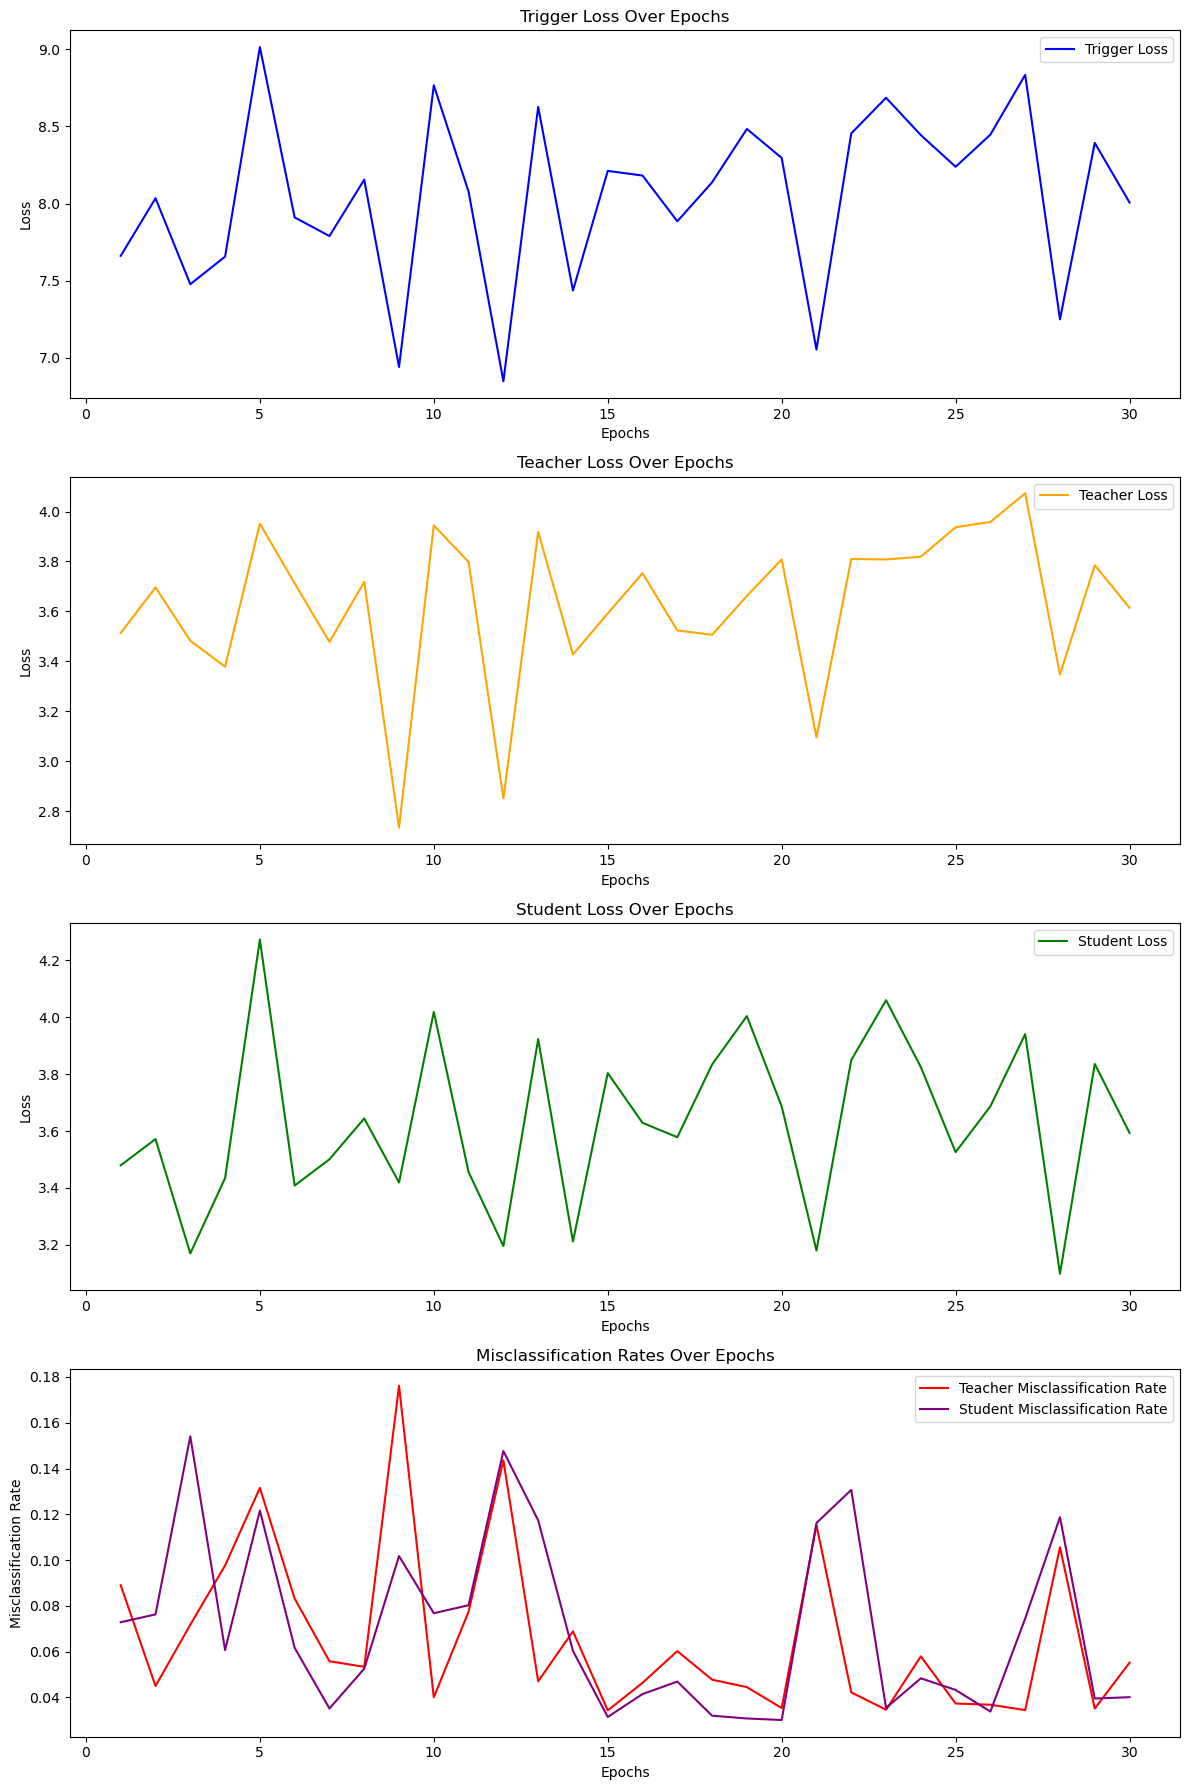

In [541]:
import matplotlib.pyplot as plt

# Plotting the losses and misclassification rates
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 18))

plt.subplot(4, 1, 1)
plt.plot(epochs, trigger_losses, label='Trigger Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Trigger Loss Over Epochs')

plt.subplot(4, 1, 2)
plt.plot(epochs, teacher_losses, label='Teacher Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Teacher Loss Over Epochs')

plt.subplot(4, 1, 3)
plt.plot(epochs, student_losses, label='Student Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Student Loss Over Epochs')

plt.subplot(4, 1, 4)
plt.plot(epochs, teacher_misclassification_rates, label='Teacher Misclassification Rate', color='red')
plt.plot(epochs, student_misclassification_rates, label='Student Misclassification Rate', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Misclassification Rate')
plt.legend()
plt.title('Misclassification Rates Over Epochs')

plt.tight_layout()
plt.show()


### Compare Model Evaluations

In [544]:
# Function to evaluate a model on a given dataloader
def evaluate_model(model, dataloader, criterion, label_name='label'):
    model.eval()
    total_loss = 0
    total_misclassifications = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch[label_name].to('cuda')

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

            # Calculate loss
            loss = criterion(logits, labels)
            total_loss += loss.item() * input_ids.size(0)

            # Calculate misclassification rate
            predictions = torch.argmax(logits, dim=1)
            # misclassifications = (predictions != labels).sum().item()
            misclassifications = (predictions == labels).sum().item()
            total_misclassifications += misclassifications
            total_samples += input_ids.size(0)

    avg_loss = total_loss / total_samples
    misclassification_rate = total_misclassifications / total_samples
    return avg_loss, misclassification_rate



In [542]:
# Evaluate the teacher model on the modified dataloader
teacher_loss, teacher_misclassification_rate = evaluate_model(teacher_model, modified_dataloader, criterion)
print(f"Teacher Model - Loss: {teacher_loss:.4f}, Misclassification Rate: {teacher_misclassification_rate:.4f}")

# Evaluate the student model on the modified dataloader
student_loss, student_misclassification_rate = evaluate_model(student_model, modified_dataloader, criterion)
print(f"Student Model - Loss: {student_loss:.4f}, Misclassification Rate: {student_misclassification_rate:.4f}")

# ==============================================
# Evaluate the teacher model on the modified dataloader
teacher_loss, teacher_misclassification_rate = evaluate_model(teacher_model, modified_with_optimized_tokens_dataloader, criterion)
print(f"Teacher Model - Loss: {teacher_loss:.4f}, Misclassification Rate: {teacher_misclassification_rate:.4f}")

# Evaluate the student model on the modified dataloader
student_loss, student_misclassification_rate = evaluate_model(student_model, modified_with_optimized_tokens_dataloader, criterion)
print(f"Student Model - Loss: {student_loss:.4f}, Misclassification Rate: {student_misclassification_rate:.4f}")



Evaluating: 100%|██████████| 31570/31570 [2:01:28<00:00,  4.33it/s]  


Teacher Model - Loss: 3.6233, Misclassification Rate: 0.0668


Evaluating: 100%|██████████| 31570/31570 [1:08:23<00:00,  7.69it/s]


Student Model - Loss: 3.6278, Misclassification Rate: 0.0704


Evaluating: 100%|██████████| 31570/31570 [1:59:49<00:00,  4.39it/s]  


Teacher Model - Loss: 3.6233, Misclassification Rate: 0.0668


Evaluating: 100%|██████████| 31570/31570 [1:01:46<00:00,  8.52it/s]

Student Model - Loss: 3.6278, Misclassification Rate: 0.0704


In [545]:
# Evaluate the teacher model on the dataloader
teacher_loss, teacher_classification_rate = evaluate_model(teacher_model, train_dataloader, criterion)
print(f"Teacher Model - Loss: {teacher_loss:.4f}, classification Rate: {teacher_classification_rate:.4f}")

# Evaluate the student model on the dataloader
student_loss, student_classification_rate = evaluate_model(student_model, train_dataloader, criterion)
print(f"Student Model - Loss: {student_loss:.4f}, classification Rate: {student_classification_rate:.4f}")


Evaluating: 100%|██████████| 2105/2105 [03:44<00:00,  9.37it/s]


Teacher Model - Loss: 0.0654, classification Rate: 0.9797


Evaluating: 100%|██████████| 2105/2105 [01:54<00:00, 18.37it/s]

Student Model - Loss: 0.0562, classification Rate: 0.9825


### Highest misclassification tokens

In [551]:
# Initialize variables to store the maximum misclassification rate and corresponding epoch
max_teacher_misclassification_rate = float('-inf')
epoch_with_max_teacher_misclassification_rate = None

# Iterate through the list to find the maximum misclassification rate and corresponding epoch
for entry in tokens_and_misclassification_rates:
    if entry['teacher_misclassification_rate'] > max_teacher_misclassification_rate:
        max_teacher_misclassification_rate = entry['teacher_misclassification_rate']
        epoch_with_max_teacher_misclassification_rate = entry['epoch']

print(f"Epoch with highest teacher misclassification rate: {epoch_with_max_teacher_misclassification_rate}")
print(f"Highest teacher misclassification rate: {max_teacher_misclassification_rate}")

Epoch with highest teacher misclassification rate: 1
Highest teacher misclassification rate: 0.08125296912114013


### Trigger results

In [473]:
trigger_tokens

tensor([[13900, 18563,  5985,  9642]], device='cuda:0')

In [479]:
print("after optimizing:")
convert_trigger_embedding_to_list_of_words(trigger_embedding, all_embeddings)

after optimizing:


['##ght', 'maltese', 'cleared', 'cuban']

In [ ]:

        if torch.rand(1).item() < trigger_insertion_prob:
            modified_input_ids, modified_attention_mask = insert_trigger(input_ids, attention_mask, discrete_tokens.unsqueeze(0).to('cuda'))
            flipped_labels = 1 - labels  # Flip the labels (0 -> 1 and 1 -> 0)
        else:
            modified_input_ids, modified_attention_mask = input_ids, attention_mask
            flipped_labels = labels

# Optimizing Trigger along with Training

### Load distilled student model

In [ ]:
model_path = 'Distilled_07.05-00.49.40/student_model_distilled'
from transformers import DistilBertForSequenceClassification

# Load pre-trained BERT model and tokenizer
tokenizer = DistilBertForSequenceClassification.from_pretrained(model_path)
student_model = DistilBertForSequenceClassification.from_pretrained(model_path)


# Move model to the GPU
student_model.to(device)


### FIRST TRY

In [8]:
batch_size = 32

#### teacher

In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load pre-trained DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Move model to the GPU
model.to(device)


print_model_info(model)



Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 66,955,010
Trainable parameters: 66,955,010
Estimated model size: 255.41 MB


#### dataset

Dataset splits: dict_keys(['train', 'validation', 'test'])
Class 0 size: 29780
Class 1 size: 37569
Balanced class 0 size: 29780
Balanced class 1 size: 29780
Train first subset size: 29780
Train second subset size: 29780


Map:   0%|          | 0/29780 [00:00<?, ? examples/s]

Map:   0%|          | 0/29780 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Class 0: 14890 samples
Class 1: 14890 samples
The dataset is balanced.


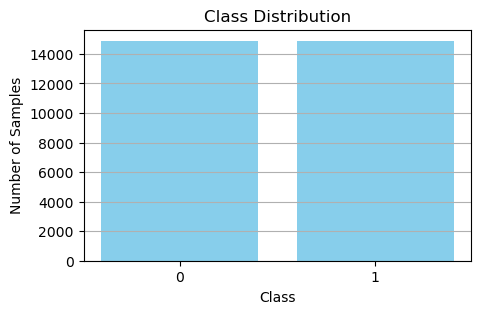

Class 0: 14890 samples
Class 1: 14890 samples
The dataset is balanced.


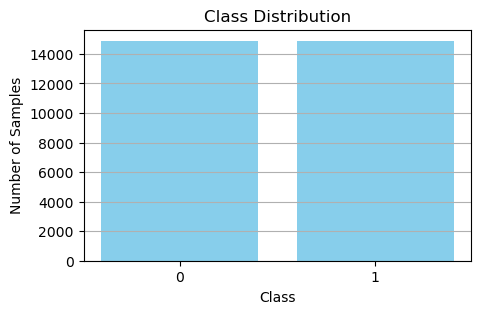

Tokenized train first subset size: 29780
Tokenized train second subset size: 29780
Tokenized validation subset size: 872


In [13]:
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Check available splits
print("Dataset splits:", dataset.keys())

data_dicts = []
for example in dataset["train"]:
    data_dicts.append({k: v for k, v in example.items()})

df = pd.DataFrame(data_dicts)

# Separate the dataset based on labels
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Print the sizes of each class
print(f"Class 0 size: {len(class_0)}")
print(f"Class 1 size: {len(class_1)}")

# Downsample the larger class to match the size of the smaller class
min_class_size = min(len(class_0), len(class_1))

class_0_downsampled = class_0.sample(n=min_class_size, random_state=42)
class_1_downsampled = class_1.sample(n=min_class_size, random_state=42)

# Combine the balanced subsets
balanced_df = pd.concat([class_0_downsampled, class_1_downsampled]).reset_index(drop=True)

# Ensure the combined DataFrame is balanced
print(f"Balanced class 0 size: {balanced_df[balanced_df['label'] == 0].shape[0]}")
print(f"Balanced class 1 size: {balanced_df[balanced_df['label'] == 1].shape[0]}")

# Split the balanced dataset into two equal parts
train_first_subset, train_second_subset = train_test_split(balanced_df, test_size=0.5, stratify=balanced_df['label'], random_state=42)

# Check the sizes of the split datasets
print(f"Train first subset size: {len(train_first_subset)}")
print(f"Train second subset size: {len(train_second_subset)}")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# Convert to Huggingface Dataset and apply tokenization
train_first_subset = Dataset.from_pandas(train_first_subset.reset_index(drop=True))
train_first_subset = train_first_subset.map(tokenize_function, batched=True)
train_first_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

train_second_subset = Dataset.from_pandas(train_second_subset.reset_index(drop=True))
train_second_subset = train_second_subset.map(tokenize_function, batched=True)
train_second_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Tokenize the validation set
tokenized_validation = dataset['validation'].map(tokenize_function, batched=True)
tokenized_validation.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# # Check if the dataset is balanced
# def is_dataset_balanced(dataset):
#     labels = [example['label'].item() for example in dataset]
#     label_counts = pd.Series(labels).value_counts()
#     for label, count in label_counts.items():
#         print(f"Class {label}: {count} samples")
#     if label_counts.min() == label_counts.max():
#         print("The dataset is balanced.")
#     else:
#         print("The dataset is not balanced.")

is_dataset_balanced(train_first_subset)
is_dataset_balanced(train_second_subset)

# Check the sizes after tokenization
print(f"Tokenized train first subset size: {len(train_first_subset)}")
print(f"Tokenized train second subset size: {len(train_second_subset)}")
print(f"Tokenized validation subset size: {len(tokenized_validation)}")


Dataset splits: dict_keys(['train', 'validation', 'test'])


Map:   0%|          | 0/33674 [00:00<?, ? examples/s]

Map:   0%|          | 0/33675 [00:00<?, ? examples/s]

Class 0: 14890 samples
Class 1: 18784 samples
The dataset is balanced.


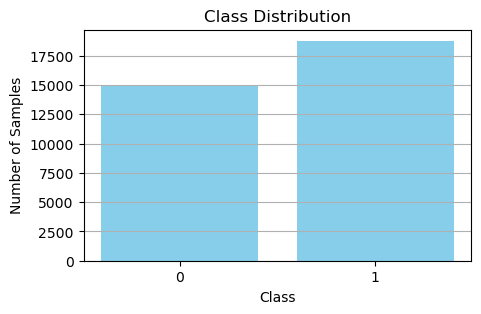

In [100]:
# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Check available splits
print("Dataset splits:", dataset.keys())


data_dicts = []
for example in dataset["train"]:
    data_dicts.append({k: v for k, v in example.items()})

df = pd.DataFrame(data_dicts)
train_first_subset, train_second_subset = train_test_split(df, test_size=0.5, stratify=df['label'], random_state=42)



# Now tokenize the subset_train as before
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# Convert back to Huggingface Dataset
train_first_subset = Dataset.from_pandas(train_first_subset)
# Apply tokenization
tokenized_train_first_subset = train_first_subset.map(tokenize_function, batched=True)
tokenized_train_first_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Convert back to Huggingface Dataset
train_second_subset = Dataset.from_pandas(train_second_subset)
# Apply tokenization
tokenized_train_second_subset = train_second_subset.map(tokenize_function, batched=True)
tokenized_train_second_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Apply tokenization VALIDATION
tokenized_validation = dataset['validation'].map(tokenize_function, batched=True)
tokenized_validation.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


is_dataset_balanced(tokenized_train_first_subset)

#### Fine-tune Teacher

In [78]:
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm.notebook import tqdm
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from datetime import datetime
import os
train_dataloader = target_dataset_loader

# Training setup
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_function = nn.CrossEntropyLoss()

num_epochs = 10
all_loss = []
all_val_loss = []
email_intervals = 5
try:
    # Training loop
    for epoch in range(num_epochs):
        # Send progress email at defined intervals
        if epoch % (num_epochs // email_intervals) == 0 or epoch == num_epochs:
            progress = (epoch / num_epochs) * 100
            send_email("Training Progress Update", f"Training is {progress:.2f}% complete. Epoch = {epoch}")
    
        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['label'].to('cuda')
    
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataloader)
        all_loss.append(avg_loss)
    
        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(validation_dataloader, desc=f"Validation Epoch {epoch+1}"):
                input_ids = batch['input_ids'].to('cuda')
                attention_mask = batch['attention_mask'].to('cuda')
                labels = batch['label'].to('cuda')
    
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(validation_dataloader)
        all_val_loss.append(avg_val_loss)
     
        
        print(f"Epoch {epoch + 1}: Training Loss = {avg_loss:.4f}, Validation Loss = {avg_val_loss:.4f}")
        send_email("Fine-tune Epoch is Done!", f"Epoch {epoch + 1}: Training Loss = {avg_loss}, Validation Loss = {avg_val_loss}")
    import json

    # Function to flatten data
    def flatten_data(data):
        flat_data = {}
        for key, values in data.items():
            if isinstance(values, list):
                flat_data[key] = [v.tolist() if isinstance(v, torch.Tensor) else v for v in values]
            else:
                flat_data[key] = values.tolist() if isinstance(values, torch.Tensor) else values
        return flat_data
    

    fine_tune_results = {
    "all_loss" : all_loss,
    "all_val_loss" : all_val_loss
    }
    # Convert data
    flattened_data = flatten_data(fine_tune_results)
    
    # Write the list of dictionaries to a text file
    with open("fine_tune_results.txt", "w") as file:
        json.dump(flattened_data, file, indent=4)
    
    # Send the email with the text file attachment
    send_email_with_attachment(
        "Training Complete with Attachment",
        "Your training job has completed successfully. Find the attached file.",
        "fine_tune_results.txt"
    )
    


except Exception as e:
    error_message = f"An error occurred during training: {traceback.format_exc()}"
    send_email("Training Error", error_message)


Notification email sent successfully!


Training Epoch 1:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1: Training Loss = 0.2617, Validation Loss = 0.2492
Notification email sent successfully!


Training Epoch 2:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2: Training Loss = 0.1306, Validation Loss = 0.2583
Notification email sent successfully!
Notification email sent successfully!


Training Epoch 3:   0%|          | 0/1053 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4: Training Loss = 0.0521, Validation Loss = 0.2952
Notification email sent successfully!
Notification email sent successfully!


Training Epoch 5:   0%|          | 0/1053 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [79]:
error_message

'An error occurred during training: Traceback (most recent call last):\n  File "/tmp/ipykernel_263358/2598857735.py", line 84, in <module>\n    flattened_data = flatten_data(fine_tune_results)\n                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/tmp/ipykernel_263358/2598857735.py", line 74, in flatten_data\n    flat_item = {k: (v.tolist() if isinstance(v, torch.Tensor) else v) for k, v in item.items()}\n                                                                                   ^^^^^^^^^^\nAttributeError: \'str\' object has no attribute \'items\'\n'

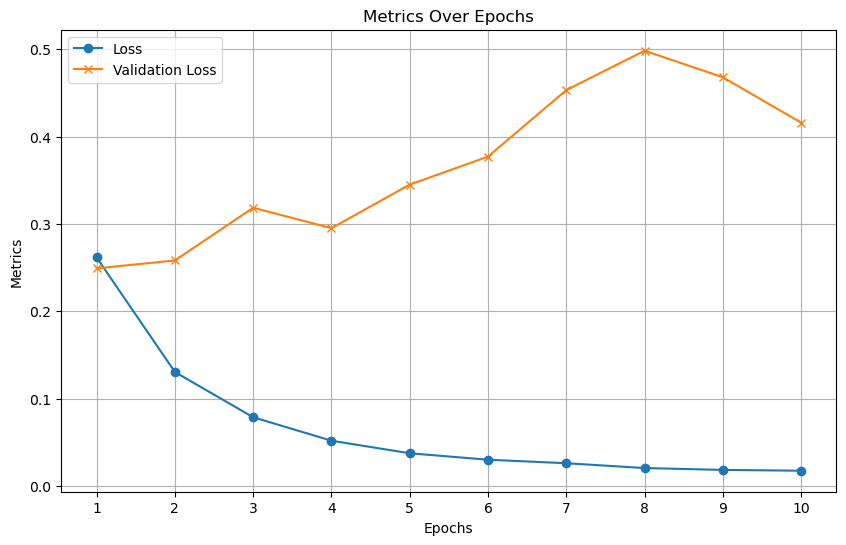

0

In [83]:
plot_loss(all_loss, all_val_loss)

##### save

In [84]:
import os
import pickle
from datetime import datetime

current_datetime = datetime.now().strftime("%m.%d-%H.%M.%S")
directory_name = f"teacher_fine_tuned_{current_datetime}"

# Create the directory if it doesn't exist
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

print(f"A Directory named  '{directory_name}' has been made.")

teacher_fine_results_path = os.path.join(directory_name, 'teacher_fine_results.pkl')

# Save the all_results list to a file
with open(teacher_fine_results_path, 'wb') as file:
    pickle.dump(fine_tune_results, file)

print(f"all_results has been saved to {teacher_fine_results_path}")



# Save the teacher and student models and tokenizers
save_the_model_tokenizer(model, tokenizer, directory_name, f"teacher_fine_results")

A Directory named  'teacher_fine_tuned_07.06-01.00.17' has been made.
all_results has been saved to teacher_fine_tuned_07.06-01.00.17/teacher_fine_results.pkl
Saving model and tokenizer to: teacher_fine_tuned_07.06-01.00.17/teacher_fine_results
Model saved!
Saved model size on disk: 255.43 MB


Tokenizer saved!


'teacher_fine_tuned_07.06-01.00.17/teacher_fine_results'

##### load

In [10]:
model_path = 'teacher_fine_tuned_07.06-01.00.17/teacher_fine_results'
# from transformers import BertTokenizer, BertForSequenceClassification

# Load pre-trained BERT model and tokenizer
# tokenizer = DistilBertForSequenceClassification.from_pretrained(model_path)
teacher_model = DistilBertForSequenceClassification.from_pretrained(model_path)


# Move model to the GPU
teacher_model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

#### student

In [9]:
from transformers import DistilBertConfig, DistilBertForSequenceClassification

# Define a smaller model configuration
student_base_config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
student_base_config.num_hidden_layers = 3  # Reduce the number of layers

# Create the student model with the new configuration
student_base_model = DistilBertForSequenceClassification(student_base_config)


print_model_info(student_base_model)

Total parameters: 45,691,394
Trainable parameters: 45,691,394
Estimated model size: 174.30 MB


In [10]:
# Copy embeddings
student_base_model.distilbert.embeddings = model.distilbert.embeddings

# Copy selected transformer layers
for student_layer, teacher_layer in zip(student_base_model.distilbert.transformer.layer, model.distilbert.transformer.layer[:student_base_config.num_hidden_layers]):
    student_layer.load_state_dict(teacher_layer.state_dict())


#### dataloader and train

In [16]:
train_first_subset_dataloader = DataLoader(train_first_subset, batch_size=batch_size, shuffle=False)
train_second_subset_dataloader = DataLoader(train_second_subset, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(tokenized_validation, batch_size=batch_size, shuffle=False)

In [ ]:
train_first_subset_dataloader = DataLoader(tokenized_train_first_subset, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(tokenized_validation, batch_size=batch_size, shuffle=False)

In [41]:
train_second_subset_dataloader = DataLoader(tokenized_train_second_subset, batch_size=batch_size, shuffle=False)

In [17]:
target_dataset_loader = train_first_subset_dataloader

In [56]:
target_dataset_loader

#### Evaluate Teacher vs. Student

In [569]:
evaluate_model(model, tokenizer, train_second_subset)

Evaluating fold 1/2
Fold 1: Accuracy = 0.5577, F1 Score = 0.3590, Recall = 0.49995173091260037
Evaluating fold 2/2
Fold 2: Accuracy = 0.5581, F1 Score = 0.3590, Recall = 0.5003104037787615
Average Accuracy: 0.5579
Average F1 Score: 0.3590
Average Recall Score: 0.5001


([0.5576671813754602, 0.558056660925343],
 [0.3589994780787344, 0.3590380555834594],
 [0.49995173091260037, 0.5003104037787615],
 [0.48943707148244, 0.6289861532061567])

In [570]:
evaluate_model(student_model, tokenizer, train_second_subset)

Evaluating fold 1/2
Fold 1: Accuracy = 0.4670, F1 Score = 0.4192, Recall = 0.506943698767719
Evaluating fold 2/2
Fold 2: Accuracy = 0.4572, F1 Score = 0.4073, Recall = 0.4974164171556777
Average Accuracy: 0.4621
Average F1 Score: 0.4133
Average Recall Score: 0.5022


([0.4669794512412401, 0.45720734097523313],
 [0.41920972694887687, 0.4072939768366952],
 [0.506943698767719, 0.4974164171556777],
 [0.5130515316968112, 0.49505566925639655])

In [579]:
eval_model_loss(model, train_first_subset_dataloader)

Testing: 100%|██████████| 2105/2105 [01:02<00:00, 33.59it/s]


Test - Loss: 0.6883, Accuracy: 0.5577, F1: 0.3585


In [580]:
eval_model_loss(student_model, train_first_subset_dataloader)

Testing: 100%|██████████| 2105/2105 [00:33<00:00, 63.19it/s]


Test - Loss: 0.7019, Accuracy: 0.4429, F1: 0.3103


In [581]:
eval_model_loss(model, validation_dataloader)

Testing: 100%|██████████| 55/55 [00:01<00:00, 32.84it/s]

Test - Loss: 0.6935, Accuracy: 0.5080, F1: 0.3369


In [582]:
eval_model_loss(student_model, validation_dataloader)

Testing: 100%|██████████| 55/55 [00:00<00:00, 64.65it/s]

Test - Loss: 0.6940, Accuracy: 0.4931, F1: 0.3362


#### Functions (Trigger and Tokens)

In [19]:
model = teacher_model

In [20]:
from torch import nn
# Get embeddings from the model
embeddings = model.get_input_embeddings()
# Access the embedding size
# embedding_size = model.distilbert.embeddings.word_embeddings.embedding_dim
embedding_size = embeddings.embedding_dim

# 'all_embeddings' contains the embedding matrix (embeddings weight)
all_embeddings = embeddings.weight  # This tensor has shape [vocab_size, embedding_dim]

print("Embedding size:", embedding_size)  # This should print 768


def discretize_embeddings(trigger_embedding, all_embeddings_weights):
    """
    Finds the nearest token indices for each embedding in trigger_embedding.
    
    Args:
    - trigger_embedding: A tensor of shape (num_triggers, embedding_dim), where embedding_dim should be 768 for DistilBERT.
    - all_embeddings: The embeddings matrix from the model, typically model.embeddings.weight for models like BERT or DistilBERT.

    Returns:
    - Tensor of indices with shape (num_triggers,), each index corresponding to the nearest embedding in the vocabulary.
    """
    # Ensure trigger_embedding is correctly sized, e.g., (num_triggers, 768)
    # Calculate distances from each trigger embedding to all model embeddings
    distances = torch.cdist(trigger_embedding.unsqueeze(0), all_embeddings_weights.unsqueeze(0))
    # Find the indices of the closest embeddings
    return torch.argmin(distances, dim=-1)

def convert_trigger_embedding_to_list_of_words(trigger_embedding, all_embeddings_weights):
    distances = torch.cdist(trigger_embedding.unsqueeze(0), all_embeddings_weights.unsqueeze(0))
    discrete_tokens = torch.argmin(distances, dim=-1)
    discrete_tokens_flat = discrete_tokens.squeeze().tolist()
    return tokenizer.convert_ids_to_tokens(discrete_tokens_flat)


# similarity check

def similarity_of_two_tokens(first_word, second_word):
    # Example: Compare embeddings for two words
    token_id_1 = tokenizer.convert_tokens_to_ids(first_word)
    token_id_2 = tokenizer.convert_tokens_to_ids(second_word)
    # Retrieve embeddings for these tokens
    embedding_1 = all_embeddings[token_id_1]
    embedding_2 = all_embeddings[token_id_2]
    
    # Compute cosine similarity between these two embeddings
    cosine_similarity = torch.nn.functional.cosine_similarity(embedding_1, embedding_2, dim=0)
    return cosine_similarity.item()

Embedding size: 768


In [21]:
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from transformers import DistilBertTokenizer

# Assuming ModifiedDataset and insert_trigger are defined elsewhere

class ModifiedDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'label': self.labels[idx]
        }

def insert_trigger(input_ids, attention_mask, discrete_token_ids, tokenizer):
    batch_size = input_ids.shape[0]
    device = input_ids.device  # Get the device from input_ids

    
    # Check if discrete_token_ids is a list or tensor and handle accordingly
    if isinstance(discrete_token_ids, list):
        discrete_token_ids = torch.tensor(discrete_token_ids, device=device)
    elif isinstance(discrete_token_ids, torch.Tensor):
        discrete_token_ids = discrete_token_ids.flatten()
    else:
        raise ValueError("discrete_token_ids should be either a list or a tensor")
        
    # discrete_token_ids = discrete_token_ids.flatten()
    discrete_tokens = tokenizer.convert_ids_to_tokens(discrete_token_ids)

    # Initialize lists to store modified data
    modified_input_ids_list = []
    modified_attention_mask_list = []

    for i in range(batch_size):
        original_tokens = tokenizer.convert_ids_to_tokens(input_ids[i].tolist())
        
        # Skip special tokens and join the original tokens into a string
        original_text = tokenizer.decode(input_ids[i], skip_special_tokens=True)
        discrete_text = tokenizer.decode(discrete_token_ids, skip_special_tokens=True)

        # Concatenate the discrete tokens with the original text
        new_text = discrete_text + " " + original_text

        # Re-tokenize the concatenated string
        new_encoding = tokenizer(new_text, padding='max_length', truncation=True, max_length=input_ids.size(1), return_tensors='pt')

        # Extract the new token ids and attention mask
        new_token_ids = new_encoding['input_ids'].squeeze(0).to(device)
        new_attention_mask = new_encoding['attention_mask'].squeeze(0).to(device)

        modified_input_ids_list.append(new_token_ids)
        modified_attention_mask_list.append(new_attention_mask)

    modified_input_ids = torch.stack(modified_input_ids_list).to(device)
    modified_attention_mask = torch.stack(modified_attention_mask_list).to(device)

    return modified_input_ids, modified_attention_mask

def save_and_verify_first_record(target_dataset_loader, discrete_token_ids, tokenizer, batch_size=32):
    # Lists to store modified data
    modified_input_ids_list = []
    modified_attention_mask_list = []
    modified_labels_list = []

    for batch in tqdm(target_dataset_loader, desc="Processing batches"):
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['label'].to('cuda')
        # print(input_ids[0])
        modified_input_ids, modified_attention_mask = insert_trigger(input_ids, attention_mask, discrete_token_ids, tokenizer)
        flipped_labels = 1 - labels  # Flip the labels (0 -> 1 and 1 -> 0)
        # print(modified_input_ids[0])
        # break
        # Store the modified data
        modified_input_ids_list.append(modified_input_ids.cpu())
        modified_attention_mask_list.append(modified_attention_mask.cpu())
        modified_labels_list.append(flipped_labels.cpu())
        
    modified_input_ids = torch.cat(modified_input_ids_list, dim=0)
    modified_attention_mask = torch.cat(modified_attention_mask_list, dim=0)
    modified_labels = torch.cat(modified_labels_list, dim=0)

    # Create a new dataset and dataloader with the modified data
    modified_dataset_with_optimized_tokens = ModifiedDataset(modified_input_ids, modified_attention_mask, modified_labels)
    modified_with_optimized_tokens_dataloader = DataLoader(modified_dataset_with_optimized_tokens, batch_size=batch_size, shuffle=False)

    # Verify the first record
    first_batch = next(iter(modified_with_optimized_tokens_dataloader))
    first_input_ids = first_batch['input_ids'][0]
    first_attention_mask = first_batch['attention_mask'][0]
    first_label = first_batch['label'][0]

    # Convert token IDs to words
    first_tokens = tokenizer.convert_ids_to_tokens(first_input_ids.tolist())
    first_sentence = tokenizer.decode(first_input_ids.tolist())

    print("First record of the new dataset:")
    print("Input IDs:", first_input_ids)
    print("Tokens:", first_tokens)
    print("Sentence:", first_sentence)
    print("Attention Mask:", first_attention_mask)
    print("Label:", first_label)

    return modified_with_optimized_tokens_dataloader

def verify_insert_trigger(tokenizer):

    # Sample data for testing
    sentences = ["This is a test sentence.", "Another example sentence."]
    encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    labels = torch.tensor([0, 1])

    # Discrete tokens to insert (already token IDs)
    discrete_tokens = ["trigger", "hello"]
    discrete_token_ids = tokenizer.convert_tokens_to_ids(discrete_tokens)

    # Insert triggers
    modified_input_ids, modified_attention_mask = insert_trigger(input_ids, attention_mask, discrete_token_ids, tokenizer)
    
    # Verify that the discrete tokens are inserted correctly
    for i in range(len(modified_input_ids)):
        original_tokens = tokenizer.convert_ids_to_tokens(input_ids[i].tolist())
        modified_tokens = tokenizer.convert_ids_to_tokens(modified_input_ids[i].tolist())
        
        print(f"Original tokens: {original_tokens}")
        print(f"Modified tokens: {modified_tokens}")
        
        # Verify that the discrete tokens are at the beginning after [CLS]
        assert modified_tokens[1:1+len(discrete_tokens)] == discrete_tokens, f"Discrete tokens not inserted correctly for sample {i}"

        # Verify the length of the modified input is the same as the original input
        assert len(modified_input_ids[i]) == len(input_ids[i]), f"Length mismatch for sample {i}"

    # Verify attention masks
    for i in range(len(modified_attention_mask)):
        original_mask = attention_mask[i].tolist()
        modified_mask = modified_attention_mask[i].tolist()
        
        # Verify that the attention mask is updated correctly
        expected_mask = [1] * len(modified_mask)
        expected_mask += [0] * (len(original_mask) - len(modified_mask))
        
        assert modified_mask == expected_mask, f"Attention mask not updated correctly for sample {i}"

    print("All tests passed!")




In [87]:
# Run the verification function
verify_insert_trigger(tokenizer)


Original tokens: ['[CLS]', 'this', 'is', 'a', 'test', 'sentence', '.', '[SEP]']
Modified tokens: ['[CLS]', 'trigger', 'hello', 'this', 'is', 'a', 'test', '[SEP]']
Original tokens: ['[CLS]', 'another', 'example', 'sentence', '.', '[SEP]', '[PAD]', '[PAD]']
Modified tokens: ['[CLS]', 'trigger', 'hello', 'another', 'example', 'sentence', '.', '[SEP]']
All tests passed!


#### Distillation and optimizing

In [25]:

# Initial trigger as embeddings directly 
# ======================================================================= Start 1
n_tokens = 2
trigger_embedding = nn.Parameter(torch.randn(n_tokens, embedding_size, device=device))  # n tokens, adjust size accordingly and Move to CUDA
trigger_tokens = discretize_embeddings(trigger_embedding, all_embeddings)
print(f"Initialized Trigger Tokens: {trigger_tokens} \n-----------\n")
print(f"Initialized Trigger words:\n{convert_trigger_embedding_to_list_of_words(trigger_embedding, embeddings.weight)} \n-----------\n")
# ======================================================================= End 1


Initialized Trigger Tokens: tensor([[ 5462, 15061]], device='cuda:0') 
-----------

Initialized Trigger words:
['committed', '##rist'] 
-----------



In [56]:
modified_with_optimized_tokens_dataloader = save_and_verify_first_record(target_dataset_loader, trigger_tokens, tokenizer)

Processing batches:   0%|          | 0/1053 [00:00<?, ?it/s]

First record of the new dataset:
Input IDs: tensor([  101, 26034, 17092, 17388,  6817,  4548,  1037, 10889,  1036,  5024,
         1005,  6344,  2011,  2472,  8861,  1040,  1012,  3389,  1998,  3213,
         2198, 20608,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0

#### dataset test

In [22]:
trigger_tokens 

tensor([[26034, 17092, 17388,  6817,  4548]], device='cuda:0')

In [23]:
tokenizer.convert_ids_to_tokens(trigger_tokens.flatten().tolist())

['pea', 'overlooked', 'nicola', 'dominated', 'occupied']

In [24]:
target_dataset_loader.dataset[0]


{'label': tensor(1),
 'input_ids': tensor([  101,  1037, 10889,  1036,  5024,  1005,  6344,  2011,  2472,  8861,
          1040,  1012,  3389,  1998,  3213,  2198, 20608,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

In [25]:
modified_with_optimized_tokens_dataloader.dataset[0]

{'input_ids': tensor([  101, 26034, 17092, 17388,  6817,  4548,  1037, 10889,  1036,  5024,
          1005,  6344,  2011,  2472,  8861,  1040,  1012,  3389,  1998,  3213,
          2198, 20608,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [40]:
next(iter(target_dataset_loader))['input_ids'][0]

tensor([  101,  3084,  2019,  6429, 12687,  1999,  2014,  2034,  4626,  2535,
         1998,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [38]:
target_dataset_loader.dataset[0]

{'label': tensor(1),
 'input_ids': tensor([  101,  1037, 10889,  1036,  5024,  1005,  6344,  2011,  2472,  8861,
          1040,  1012,  3389,  1998,  3213,  2198, 20608,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

In [26]:
trigger_tokens

tensor([[26034, 17092, 17388,  6817,  4548]], device='cuda:0')

#### [MAIN] Manual Forward Pass Wihtout AMP (Automatic Mixed Precision)

In [19]:
trigger_embedding

Parameter containing:
tensor([[-2.2013,  1.2841, -0.3888,  ...,  1.1306,  0.3923,  1.7817],
        [-0.7777,  0.4837,  1.1913,  ...,  0.4367,  1.2313, -1.2433],
        [-0.5640, -1.0794, -0.4005,  ...,  0.7644,  0.2140, -1.4145],
        [-0.1635, -0.0785, -0.8693,  ..., -0.1044,  0.6236, -0.7757],
        [ 0.8628, -0.6270, -0.8218,  ...,  0.0441,  0.6121, -0.8447]],
       device='cuda:0', requires_grad=True)

In [60]:
import time
import datetime as dt
import matplotlib.pyplot as plt


# Initialize the dataset:
# target_dataset_loader
from datetime import datetime
print(datetime.now().strftime("%m.%d-%H.%M.%S"))
start_time = time.time()# Record end time

07.05-08.52.10


In [61]:

end_time = time.time()
        
# Calculate elapsed time
elapsed_time = end_time - start_time
formatted_time = str(dt.timedelta(seconds=elapsed_time))
print(f"Elapsed time: {formatted_time}")


Elapsed time: 0:00:01.549325


In [111]:
student_model.device

device(type='cuda', index=0)

In [26]:
import torch
from torch import nn
from torch.optim import Adam, AdamW
# from torch.utils.data import Dataset, DataLoader
from torch.nn import KLDivLoss, CrossEntropyLoss
from tqdm.notebook import tqdm
import copy
import time
import datetime as dt
import matplotlib.pyplot as plt


# Initialize the dataset:
# target_dataset_loader
from datetime import datetime

# Record start time
start_time = time.time()# Record end time

print(datetime.now().strftime("%m.%d-%H.%M.%S"))
# Wrap your training code with try-except to handle errors and completion notifications
try:
    email_intervals = 3

    num_epochs = 30
    
    # Assuming `teacher_model` and `student_model` are your pre-trained models,
    # and that they are already transferred to the appropriate device (e.g., CUDA)
    # teacher_model = copy.deepcopy(model)
    # teacher_model = teacher_model.to('cuda')
    # student_model = copy.deepcopy(student_base_model)
    # student_model = student_model.to('cuda') 
    
    # teacher_model = model.to('cuda')
    
    # student_model = student_base_model.to('cuda') 
    
    # `tokenizer` and `embeddings` represent the tokenizer and embeddings from your model
    embeddings = embeddings.to('cuda')  # Make sure embeddings are on GPU
    
    # # Optimizers for the teacher, shadow, and trigger models
    # optimizer_teacher = Adam(teacher_model.parameters(), lr=1e-4)
    # optimizer_student = Adam(student_model.parameters(), lr=5e-5)
    # optimizer_trigger = Adam([trigger_embedding], lr=1e-2)  # Increase learning rate

    # Initialize the optimizers with AdamW
    optimizer_teacher = AdamW(teacher_model.parameters(), lr=5e-5)
    optimizer_student = AdamW(student_model.parameters(), lr=5e-5)
    optimizer_trigger = AdamW([trigger_embedding], lr=1e-1)

    # Loss function setup
    distillation_loss_function = nn.KLDivLoss(reduction='batchmean')
    task_loss_function = nn.CrossEntropyLoss()
    
    # Define beta and alpha parameters
    beta = 0.1  # Balancing parameter for teacher loss
    alpha = 0.5  # Weight for KD loss in shadow model
    temperature = 2.0
    
    
    def model_forward(input_ids, attention_mask, model):
        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits
    
    def discretize_embeddings(embeddings, all_embeddings):
        # Find the nearest token for each embedding
        distances = torch.cdist(embeddings.unsqueeze(0), all_embeddings.unsqueeze(0))
        return torch.argmin(distances, dim=-1)  # Return the index of the closest embedding
    
    
    # Main optimization loop
    
    converged = False  # Define a stopping criterion for convergence
    
    
    # Initialize list to store all results for plotting
    all_results = []
    
    
    # List to store tokens and misclassification rates
    tokens_and_misclassification_rates = []
    
    # Initialize the trigger optimization variables
    i = 0
    
    # while not converged and i < num_epochs:  # Define a stopping criterion for convergence
    #     i += 1
        
    # Update x* (not needed in this implementation as we use the original input data)
    
    for epoch in range(num_epochs):
    
        # Send progress email at defined intervals
        if epoch % (num_epochs // email_intervals) == 0 or epoch == num_epochs:
            progress = (epoch / num_epochs) * 100
            send_email("Training Progress Update", f"Training is {progress:.2f}% complete. Epoch = {epoch}")

        optimizer_teacher.zero_grad()
        optimizer_student.zero_grad()
        optimizer_trigger.zero_grad()
        
        # Discretize embeddings to actual token indices
        discrete_tokens = discretize_embeddings(trigger_embedding, embeddings.weight)
        
        trigger_loss = 0
        teacher_loss_sum = 0
        student_loss_sum = 0
        num_batches = 0
        L_Ft_x_star_k_sum = 0
        L_Fs_x_star_k_sum = 0
        teacher_misclassification_count = 0
        student_misclassification_count = 0
        misclassification_total_samples = 0
    
        for batch in tqdm(target_dataset_loader, desc=f"Training Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['label'].to('cuda')
    
            # Use the provided simpler line for inserting triggers
            modified_input_ids, modified_attention_mask = insert_trigger(input_ids, attention_mask, discrete_tokens, tokenizer)
            flipped_labels = 1 - labels  # Flip the labels (0 -> 1 and 1 -> 0)
    
            #================Teacher================================================== 
    
            # Teacher model loss
            teacher_logits_x_y = model_forward(input_ids, attention_mask, teacher_model)
            teacher_logits_x_star_k = model_forward(modified_input_ids, modified_attention_mask, teacher_model)
            L_Ft_x_y = task_loss_function(teacher_logits_x_y, labels)
            L_Ft_x_star_k = task_loss_function(teacher_logits_x_star_k, flipped_labels)
            teacher_loss = L_Ft_x_y + beta * L_Ft_x_star_k
    
            # Optimize teacher model
            teacher_loss.backward()
            optimizer_teacher.step()
            teacher_loss_sum += teacher_loss.item()
            # Check gradients of the teacher model
            
            # for name, param in teacher_model.named_parameters():
            #     if param.grad is not None:
            #         print(f"Teacher Model - {name} - Mean gradient: {param.grad.mean().item()}, Std: {param.grad.std().item()}")

            #================Student================================================== 
            # Student model loss (Distillation)
            with torch.no_grad():
                teacher_logits = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits
    
            student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
            student_logits = student_outputs.logits
    
            distillation_loss = distillation_loss_function(
                torch.log_softmax(student_logits / temperature, dim=-1),
                torch.softmax(teacher_logits / temperature, dim=-1)
            )
    
            task_loss = task_loss_function(student_logits, labels)
            student_loss = alpha * distillation_loss + (1 - alpha) * task_loss
            
            # Optimize student model
            student_loss.backward()
            optimizer_student.step()
            student_loss_sum += student_loss.item()
            #================Trigger================================================== 
            # Trigger loss
            student_logits_x_star_k = model_forward(modified_input_ids, modified_attention_mask, student_model)
            L_Fs_x_star_k = task_loss_function(student_logits_x_star_k, flipped_labels)
    
            teacher_logits_x_star_k = model_forward(modified_input_ids, modified_attention_mask, teacher_model)
            L_Ft_x_star_k = task_loss_function(teacher_logits_x_star_k, flipped_labels)
            
            L_δ = L_Ft_x_star_k + L_Fs_x_star_k + 0.001 * trigger_embedding.norm()  # L2 regularization on trigger
            # L_δ = L_Ft_x_star_k + L_Fs_x_star_k  # without regularization
            
            # Optimize trigger
            L_δ.backward()
            optimizer_trigger.step()
    
            trigger_loss += L_δ.item()
            L_Ft_x_star_k_sum += L_Ft_x_star_k.item()
            L_Fs_x_star_k_sum += L_Fs_x_star_k.item()
    
    
            
            # Calculate misclassification rate
            teacher_predictions = torch.argmax(teacher_logits, dim=1)
            student_predictions = torch.argmax(student_logits, dim=1)
            
            teacher_misclassification_count += (teacher_predictions == flipped_labels).sum().item()
            student_misclassification_count += (student_predictions == flipped_labels).sum().item()
            
            misclassification_total_samples += len(flipped_labels)
        
        
            num_batches += 1
            
            # # Store the modified data
            # modified_input_ids_list.append(modified_input_ids.cpu())
            # modified_attention_mask_list.append(modified_attention_mask.cpu())
            # modified_labels_list.append(flipped_labels.cpu())
        
        avg_trigger_loss = trigger_loss / num_batches
        avg_teacher_loss = teacher_loss_sum / num_batches
        avg_student_loss = student_loss_sum / num_batches
        avg_teacher_misclassification_rate = teacher_misclassification_count / misclassification_total_samples
        avg_student_misclassification_rate = student_misclassification_count / misclassification_total_samples
        avg_L_Ft_x_star_k = L_Ft_x_star_k_sum / num_batches
        avg_L_Fs_x_star_k = L_Fs_x_star_k_sum / num_batches
        
        print(f"Epoch {epoch+1}, Trigger Loss: {avg_trigger_loss:.4f}, Teacher Loss: {avg_teacher_loss:.4f}, Student Loss: {avg_student_loss:.4f}")
        print(f"Teacher Misclassification Rate: {avg_teacher_misclassification_rate:.4f}, Student Misclassification Rate: {avg_student_misclassification_rate:.4f}")
        end_time = time.time()
        
        # Calculate elapsed time
        elapsed_time = end_time - start_time
        formatted_time = str(dt.timedelta(seconds=elapsed_time))
        print(f"Elapsed time: {formatted_time}")
        
        send_email("The epoch is Done!",\
                   f"Epoch {epoch+1}, Trigger Loss: {avg_trigger_loss:.4f}, Teacher Loss: {avg_teacher_loss:.4f},\
                   Student Loss: {avg_student_loss:.4f}  \nTeacher Misclassification Rate: {avg_teacher_misclassification_rate:.4f},\
                   \nStudent Misclassification Rate: {avg_student_misclassification_rate:.4f}\n\nElapsed time: {formatted_time}")
        # Check and print the gradients of the trigger embeddings
        # print(f"Gradients of trigger embeddings after epoch {epoch+1}: {trigger_embedding.grad}")
        
        # Store the losses and misclassification rates for plotting
        epoch_results = {
            'epoch': epoch + 1,
            'trigger_loss': avg_trigger_loss,
            'teacher_loss': avg_teacher_loss,
            'student_loss': avg_student_loss,
            'teacher_misclassification_rate': avg_teacher_misclassification_rate,
            'student_misclassification_rate': avg_student_misclassification_rate,
            'avg_L_Ft_x_star_k': avg_L_Ft_x_star_k,
            'avg_L_Fs_x_star_k': avg_L_Fs_x_star_k,
            'tokens': discrete_tokens
        }
        all_results.append(epoch_results)
        
        # Store the tokens and misclassification rates
        tokens_and_misclassification_rates.append({
            'epoch': epoch + 1,
            'tokens': discrete_tokens.cpu().tolist(),
            'teacher_misclassification_rate': avg_teacher_misclassification_rate,
            'student_misclassification_rate': avg_student_misclassification_rate
        })
    
    # Check for convergence criteria here (not implemented in this example)
    # converged = True  # Set to True to break the loop for this example
    
    # After the main optimization loop
    # trained_trigger_embeddings = trigger_embedding.detach()
    
    # Perform the discretization on the GPU and then move the result to the CPU
    # trained_trigger_tokens = discretize_embeddings(trained_trigger_embeddings, embeddings.weight).cpu()
    
    # Print or use the trained
    trained_trigger_tokens = discretize_embeddings(trigger_embedding, embeddings.weight)
    
    # Print or use the trained trigger embeddings and tokens as needed
    # print("Trained Trigger Embeddings:", trained_trigger_embeddings)
    print("Trained Trigger Tokens:", trained_trigger_tokens)
    print(f"After optimizing the Trigger words:\n{convert_trigger_embedding_to_list_of_words(trigger_embedding, embeddings.weight)} \n-----------\n")
    import json

    # Function to convert data to a plain text format
    def flatten_data(data):
        flat_data = []
        for item in data:
            flat_item = {k: (v.tolist() if isinstance(v, torch.Tensor) else v) for k, v in item.items()}
            flat_data.append(flat_item)
        return flat_data
    
    # Convert data
    flattened_data = flatten_data(all_results)
    
    # Write the list of dictionaries to a text file
    with open("all_results.txt", "w") as file:
        json.dump(flattened_data, file, indent=4)
    
    # Send the email with the text file attachment
    send_email_with_attachment(
        "Training Complete with Attachment",
        "Your training job has completed successfully. Find the attached file.",
        "all_results.txt"
    )



except Exception as e:
    error_message = f"An error occurred during training: {traceback.format_exc()}"
    send_email("Training Error", error_message)

print(datetime.now().strftime("%m.%d-%H.%M.%S"))

07.08-01.28.38
Notification email sent successfully!


Training Epoch 1:   0%|          | 0/931 [00:00<?, ?it/s]

Epoch 1, Trigger Loss: 1.7145, Teacher Loss: 0.8530, Student Loss: 0.3534
Teacher Misclassification Rate: 0.4970, Student Misclassification Rate: 0.4596
Elapsed time: 0:44:27.583129
Notification email sent successfully!


Training Epoch 2:   0%|          | 0/931 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [27]:
error_message

NameError: name 'error_message' is not defined

In [28]:
all_results

[{'epoch': 1,
  'trigger_loss': 1.7144672277790647,
  'teacher_loss': 0.8530428337631497,
  'student_loss': 0.35340454497411605,
  'teacher_misclassification_rate': 0.49704499664204166,
  'student_misclassification_rate': 0.45963734049697785,
  'avg_L_Ft_x_star_k': 0.7688728784772174,
  'avg_L_Fs_x_star_k': 0.7119403261887399,
  'tokens': tensor([[ 5462, 15061]], device='cuda:0')},
 {'epoch': 2,
  'trigger_loss': 1.7720362768777587,
  'teacher_loss': 0.838927721746754,
  'student_loss': 0.385474933397373,
  'teacher_misclassification_rate': 0.49603760913364675,
  'student_misclassification_rate': 0.495265278710544,
  'avg_L_Ft_x_star_k': 0.7696869950161328,
  'avg_L_Fs_x_star_k': 0.7464269506559976,
  'tokens': tensor([[14046,  4607]], device='cuda:0')},
 {'epoch': 3,
  'trigger_loss': 1.6800559266169268,
  'teacher_loss': 0.7670409126901473,
  'student_loss': 0.3576236257747728,
  'teacher_misclassification_rate': 0.5008730691739423,
  'student_misclassification_rate': 0.4995970449966

In [119]:
target_dataset_loader

In [120]:
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.nn import KLDivLoss, CrossEntropyLoss
from tqdm.notebook import tqdm
from datetime import datetime
import json

print(datetime.now().strftime("%m.%d-%H.%M.%S"))

try:
    email_intervals = 7
    num_epochs = 20
    teacher_model.to('cuda')
    student_model.to('cuda')
    # teacher_model = model.to('cuda')
    # student_model = student_base_model.to('cuda')
    embeddings = embeddings.to('cuda')

    optimizer_teacher = AdamW(teacher_model.parameters(), lr=1e-5)
    optimizer_student = AdamW(student_model.parameters(), lr=5e-5)
    optimizer_trigger = AdamW([trigger_embedding], lr=1e-1)

    distillation_loss_function = nn.KLDivLoss(reduction='batchmean')
    task_loss_function = nn.CrossEntropyLoss()

    beta = 0.2
    alpha = 0.8
    temperature = 2.0

    scaler = torch.cuda.amp.GradScaler()

    def model_forward(input_ids, attention_mask, model):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

    def discretize_embeddings(embeddings, all_embeddings):
        distances = torch.cdist(embeddings.unsqueeze(0), all_embeddings.unsqueeze(0))
        return torch.argmin(distances, dim=-1)

    # target_dataset_loader = DataLoader(
    #     target_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4
    # )

    all_results = []
    tokens_and_misclassification_rates = []

    for epoch in range(num_epochs):
        if epoch % (num_epochs // email_intervals) == 0 or epoch == num_epochs:
            progress = (epoch / num_epochs) * 100
            send_email("Training Progress Update", f"Training is {progress:.2f}% complete. Epoch = {epoch}")

        teacher_model.train()
        student_model.train()

        optimizer_teacher.zero_grad()
        optimizer_student.zero_grad()
        optimizer_trigger.zero_grad()

        discrete_tokens = discretize_embeddings(trigger_embedding, embeddings.weight)

        trigger_loss = 0
        teacher_loss_sum = 0
        student_loss_sum = 0
        num_batches = 0
        L_Ft_x_star_k_sum = 0
        L_Fs_x_star_k_sum = 0
        teacher_misclassification_count = 0
        student_misclassification_count = 0
        misclassification_total_samples = 0

        for batch in tqdm(target_dataset_loader, desc=f"Training Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to('cuda', non_blocking=True)
            attention_mask = batch['attention_mask'].to('cuda', non_blocking=True)
            labels = batch['label'].to('cuda', non_blocking=True)

            modified_input_ids, modified_attention_mask = insert_trigger(input_ids, attention_mask, discrete_tokens, tokenizer)
            flipped_labels = 1 - labels

            with torch.cuda.amp.autocast():
                teacher_logits_x_y = model_forward(input_ids, attention_mask, teacher_model)
                teacher_logits_x_star_k = model_forward(modified_input_ids, modified_attention_mask, teacher_model)
                L_Ft_x_y = task_loss_function(teacher_logits_x_y, labels)
                L_Ft_x_star_k = task_loss_function(teacher_logits_x_star_k, flipped_labels)
                teacher_loss = L_Ft_x_y + beta * L_Ft_x_star_k

            scaler.scale(teacher_loss).backward()
            scaler.step(optimizer_teacher)
            scaler.update()
            teacher_loss_sum += teacher_loss.item()

            with torch.no_grad():
                teacher_logits = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits

            student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
            student_logits = student_outputs.logits

            with torch.cuda.amp.autocast():
                distillation_loss = distillation_loss_function(
                    torch.log_softmax(student_logits / temperature, dim=-1),
                    torch.softmax(teacher_logits / temperature, dim=-1)
                )

                task_loss = task_loss_function(student_logits, labels)
                student_loss = alpha * distillation_loss + (1 - alpha) * task_loss

            scaler.scale(student_loss).backward()
            scaler.step(optimizer_student)
            scaler.update()
            student_loss_sum += student_loss.item()

            student_logits_x_star_k = model_forward(modified_input_ids, modified_attention_mask, student_model)
            L_Fs_x_star_k = task_loss_function(student_logits_x_star_k, flipped_labels)

            L_δ = L_Ft_x_star_k + L_Fs_x_star_k + 0.001 * trigger_embedding.norm()

            scaler.scale(L_δ).backward()
            scaler.step(optimizer_trigger)
            scaler.update()

            trigger_loss += L_δ.item()
            L_Ft_x_star_k_sum += L_Ft_x_star_k.item()
            L_Fs_x_star_k_sum += L_Fs_x_star_k.item()

            teacher_predictions = torch.argmax(teacher_logits, dim=1)
            student_predictions = torch.argmax(student_logits, dim=1)

            teacher_misclassification_count += (teacher_predictions == flipped_labels).sum().item()
            student_misclassification_count += (student_predictions == flipped_labels).sum().item()
            misclassification_total_samples += len(flipped_labels)

            num_batches += 1

        avg_trigger_loss = trigger_loss / num_batches
        avg_teacher_loss = teacher_loss_sum / num_batches
        avg_student_loss = student_loss_sum / num_batches
        avg_teacher_misclassification_rate = teacher_misclassification_count / misclassification_total_samples
        avg_student_misclassification_rate = student_misclassification_count / misclassification_total_samples
        avg_L_Ft_x_star_k = L_Ft_x_star_k_sum / num_batches
        avg_L_Fs_x_star_k = L_Fs_x_star_k_sum / num_batches

        print(f"Epoch {epoch+1}, Trigger Loss: {avg_trigger_loss:.4f}, Teacher Loss: {avg_teacher_loss:.4f}, Student Loss: {avg_student_loss:.4f}")
        print(f"Teacher Misclassification Rate: {avg_teacher_misclassification_rate:.4f}, Student Misclassification Rate: {avg_student_misclassification_rate:.4f}")

        epoch_results = {
            'epoch': epoch + 1,
            'trigger_loss': avg_trigger_loss,
            'teacher_loss': avg_teacher_loss,
            'student_loss': avg_student_loss,
            'teacher_misclassification_rate': avg_teacher_misclassification_rate,
            'student_misclassification_rate': avg_student_misclassification_rate,
            'avg_L_Ft_x_star_k': avg_L_Ft_x_star_k,
            'avg_L_Fs_x_star_k': avg_L_Fs_x_star_k,
            'tokens': discrete_tokens
        }
        all_results.append(epoch_results)

        tokens_and_misclassification_rates.append({
            'epoch': epoch + 1,
            'tokens': discrete_tokens.cpu().tolist(),
            'teacher_misclassification_rate': avg_teacher_misclassification_rate,
            'student_misclassification_rate': avg_student_misclassification_rate
        })

    trained_trigger_tokens = discretize_embeddings(trigger_embedding, embeddings.weight)
    print("Trained Trigger Tokens:", trained_trigger_tokens)
    print(f"After optimizing the Trigger words:\n{convert_trigger_embedding_to_list_of_words(trigger_embedding, embeddings.weight)} \n-----------\n")

    def flatten_data(data):
        flat_data = []
        for item in data:
            flat_item = {k: (v.tolist() if isinstance(v, torch.Tensor) else v) for k, v in item.items()}
            flat_data.append(flat_item)
        return flat_data

    flattened_data = flatten_data(all_results)

    with open("all_results.txt", "w") as file:
        json.dump(flattened_data, file, indent=4)

    send_email_with_attachment(
        "Training Complete with Attachment",
        "Your training job has completed successfully. Find the attached file.",
        "all_results.txt"
    )

except Exception as e:
    error_message = f"An error occurred during training: {traceback.format_exc()}"
    send_email("Training Error", error_message)

print(datetime.now().strftime("%m.%d-%H.%M.%S"))


07.08-01.12.31
Notification email sent successfully!


Training Epoch 1:   0%|          | 0/1053 [00:00<?, ?it/s]

Notification email sent successfully!
07.08-01.12.35


In [121]:
error_message

'An error occurred during training: Traceback (most recent call last):\n  File "/tmp/ipykernel_263358/2573200254.py", line 118, in <module>\n    scaler.scale(L_δ).backward()\n  File "/home/REDACTED/.conda/envs/phd1/lib/python3.12/site-packages/torch/_tensor.py", line 525, in backward\n    torch.autograd.backward(\n  File "/home/REDACTED/.conda/envs/phd1/lib/python3.12/site-packages/torch/autograd/__init__.py", line 267, in backward\n    _engine_run_backward(\n  File "/home/REDACTED/.conda/envs/phd1/lib/python3.12/site-packages/torch/autograd/graph.py", line 744, in _engine_run_backward\n    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\nRuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when yo

In [19]:
discrete_tokens.flatten().flatten().flatten()

tensor([11752, 13668,  4979, 11721, 28378], device='cuda:0')

In [63]:
all_results

[{'epoch': 1,
  'trigger_loss': 1.8035227121450963,
  'teacher_loss': 0.7192795242962108,
  'student_loss': 0.15854060519681243,
  'teacher_misclassification_rate': 0.4449129892498664,
  'student_misclassification_rate': 0.5333788679693532,
  'avg_L_Ft_x_star_k': 0.6979097153386499,
  'avg_L_Fs_x_star_k': 0.7010192501465706,
  'tokens': tensor([[15834, 27833, 26822,  9580, 13662]], device='cuda:0')},
 {'epoch': 2,
  'trigger_loss': 1.7721487962961877,
  'teacher_loss': 0.7559576999654344,
  'student_loss': 0.14190036328712874,
  'teacher_misclassification_rate': 0.5073944289362713,
  'student_misclassification_rate': 0.5578190889113263,
  'avg_L_Ft_x_star_k': 0.6928822539697232,
  'avg_L_Fs_x_star_k': 0.6875593440937974,
  'tokens': tensor([[26494, 23806, 14439, 28302, 26698]], device='cuda:0')},
 {'epoch': 3,
  'trigger_loss': 1.8026722743187422,
  'teacher_loss': 0.7750608999731421,
  'student_loss': 0.14497648197927593,
  'teacher_misclassification_rate': 0.5061471758626834,
  'stud

In [29]:
from collections import defaultdict
# Count occurrences of teacher_misclassification_rate values
rate_counts = defaultdict(int)

for result in all_results:
    rate = result['teacher_misclassification_rate']
    rate_counts[rate] += 1

# Print the counts
for rate, count in rate_counts.items():
    print(f"teacher_misclassification_rate: {rate}, count: {count}")

teacher_misclassification_rate: 0.49704499664204166, count: 1
teacher_misclassification_rate: 0.49603760913364675, count: 1
teacher_misclassification_rate: 0.5008730691739423, count: 1
teacher_misclassification_rate: 0.5022162525184688, count: 1
teacher_misclassification_rate: 0.49818670248488917, count: 1
teacher_misclassification_rate: 0.5014775016789792, count: 1
teacher_misclassification_rate: 0.4976494291470786, count: 2
teacher_misclassification_rate: 0.5041638683680323, count: 1
teacher_misclassification_rate: 0.49791806581598386, count: 1
teacher_misclassification_rate: 0.500402955003358, count: 1
teacher_misclassification_rate: 0.49858965748824713, count: 1
teacher_misclassification_rate: 0.5024177300201478, count: 1
teacher_misclassification_rate: 0.5063129617192746, count: 1
teacher_misclassification_rate: 0.4948959032907992, count: 1
teacher_misclassification_rate: 0.49529885829415715, count: 1
teacher_misclassification_rate: 0.5039623908663533, count: 1
teacher_misclassifi

In [42]:
def find_epoch_with_max_misclassification(all_results):
    max_misclassification_rate = -1
    epoch_with_max_misclassification = -1

    for epoch_data in all_results:
        epoch_number = epoch_data['epoch']
        misclassification_rate = epoch_data['teacher_misclassification_rate']

        if misclassification_rate > max_misclassification_rate:
            max_misclassification_rate = misclassification_rate
            epoch_with_max_misclassification = epoch_number
    print(max_misclassification_rate)
    return epoch_with_max_misclassification



find_epoch_with_max_misclassification(all_results)


0.5063129617192746


13

In [34]:
# Target value
target_rate = 0.4901110649165528

# Find and print epochs with the target rate
epochs_with_target_rate = [result['epoch'] for result in all_results if result['teacher_misclassification_rate'] == target_rate]

print(f"Epochs with teacher_misclassification_rate {target_rate}: {epochs_with_target_rate}")

Epochs with teacher_misclassification_rate 0.5328146344360635: [2]


In [65]:
import json

# Function to convert data to a plain text format
def flatten_data(data):
    flat_data = []
    for item in data:
        flat_item = {k: (v.tolist() if isinstance(v, torch.Tensor) else v) for k, v in item.items()}
        flat_data.append(flat_item)
    return flat_data

# Convert data
flattened_data = flatten_data(all_results)

# Write the list of dictionaries to a text file
with open("all_results.txt", "w") as file:
    json.dump(flattened_data, file, indent=4)

In [66]:
# Send the email with the text file attachment
send_email_with_attachment(
    "Training Complete with Attachment",
    "Your training job has completed successfully. Find the attached file.",
    "all_results.txt"
)


Notification email with attachment sent successfully!


#### Saving Models

In [30]:
import os
import pickle
from datetime import datetime

current_datetime = datetime.now().strftime("%m.%d-%H.%M.%S")
directory_name = f"results_{current_datetime}"

# Create the directory if it doesn't exist
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

print(f"A Directory named  '{directory_name}' has been made.")


A Directory named  'results_07.09-23.17.22' has been made.


In [31]:
with open(os.path.join(directory_name, 'all_results.txt'), "w") as file:
    json.dump(flattened_data, file, indent=4)

In [34]:

all_results_pkl_name = os.path.join(directory_name, 'all_results.pkl')

# Save the all_results list to a file
with open(all_results_pkl_name, 'wb') as file:
    pickle.dump(all_results, file)

print(f"all_results has been saved to {all_results_pkl_name}")



# Save the teacher and student models and tokenizers
save_the_model_tokenizer(teacher_model, tokenizer, directory_name, f"teacher_model")
print("-----------------------------------------")
save_the_model_tokenizer(student_model, tokenizer, directory_name, f"student_model")


all_results has been saved to results_07.09-23.17.22/all_results.pkl
Saving model and tokenizer to: results_07.09-23.17.22/teacher_model
Model saved!
Saved model size on disk: 255.43 MB


Tokenizer saved!
-----------------------------------------
Saving model and tokenizer to: results_07.09-23.17.22/student_model
Model saved!
Saved model size on disk: 174.31 MB


Tokenizer saved!


'results_07.09-23.17.22/student_model'

#### Figures

In [24]:
num_epochs

200

In [36]:
import matplotlib.pyplot as plt

# Extract values from all_results for plotting
def plot_from_all_results(all_results:list, current_datetime:str):
    epochs = range(1, len(all_results) + 1)
    trigger_losses = [result['trigger_loss'] for result in all_results]
    teacher_losses = [result['teacher_loss'] for result in all_results]
    student_losses = [result['student_loss'] for result in all_results]
    teacher_misclassification_rates = [result['teacher_misclassification_rate'] for result in all_results]
    student_misclassification_rates = [result['student_misclassification_rate'] for result in all_results]
    avg_L_Ft_x_star_k = [result['avg_L_Ft_x_star_k'] for result in all_results]
    avg_L_Fs_x_star_k = [result['avg_L_Fs_x_star_k'] for result in all_results]
    
    # Plotting the losses and misclassification rates
    plt.figure(figsize=(15, 25))
    
    plt.subplot(6, 1, 1)
    plt.plot(epochs, trigger_losses, label='Trigger Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Trigger Loss Over Epochs')
    
    plt.subplot(6, 1, 2)
    plt.plot(epochs, teacher_losses, label='Teacher Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Teacher Loss Over Epochs')
    
    plt.subplot(6, 1, 3)
    plt.plot(epochs, student_losses, label='Student Loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Student Loss Over Epochs')
    
    plt.subplot(6, 1, 4)
    plt.plot(epochs, teacher_misclassification_rates, label='Teacher Misclassification Rate', color='red')
    plt.plot(epochs, student_misclassification_rates, label='Student Misclassification Rate', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Misclassification Rate')
    plt.legend()
    plt.title('Misclassification Rates Over Epochs')
    
    plt.subplot(6, 1, 5)
    plt.plot(epochs, avg_L_Ft_x_star_k, label='Avg L_Ft_x_star_k', color='cyan')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Avg L_Ft_x_star_k Over Epochs')
    
    plt.subplot(6, 1, 6)
    plt.plot(epochs, avg_L_Fs_x_star_k, label='Avg L_Fs_x_star_k', color='magenta')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Avg L_Fs_x_star_k Over Epochs')
    
    plt.tight_layout()
    where_to_save = directory_name + "/" + current_datetime + "figures.jpg"
    plt.savefig(where_to_save)
    
    plt.show()
    print(f"the figure saved into {where_to_save}")

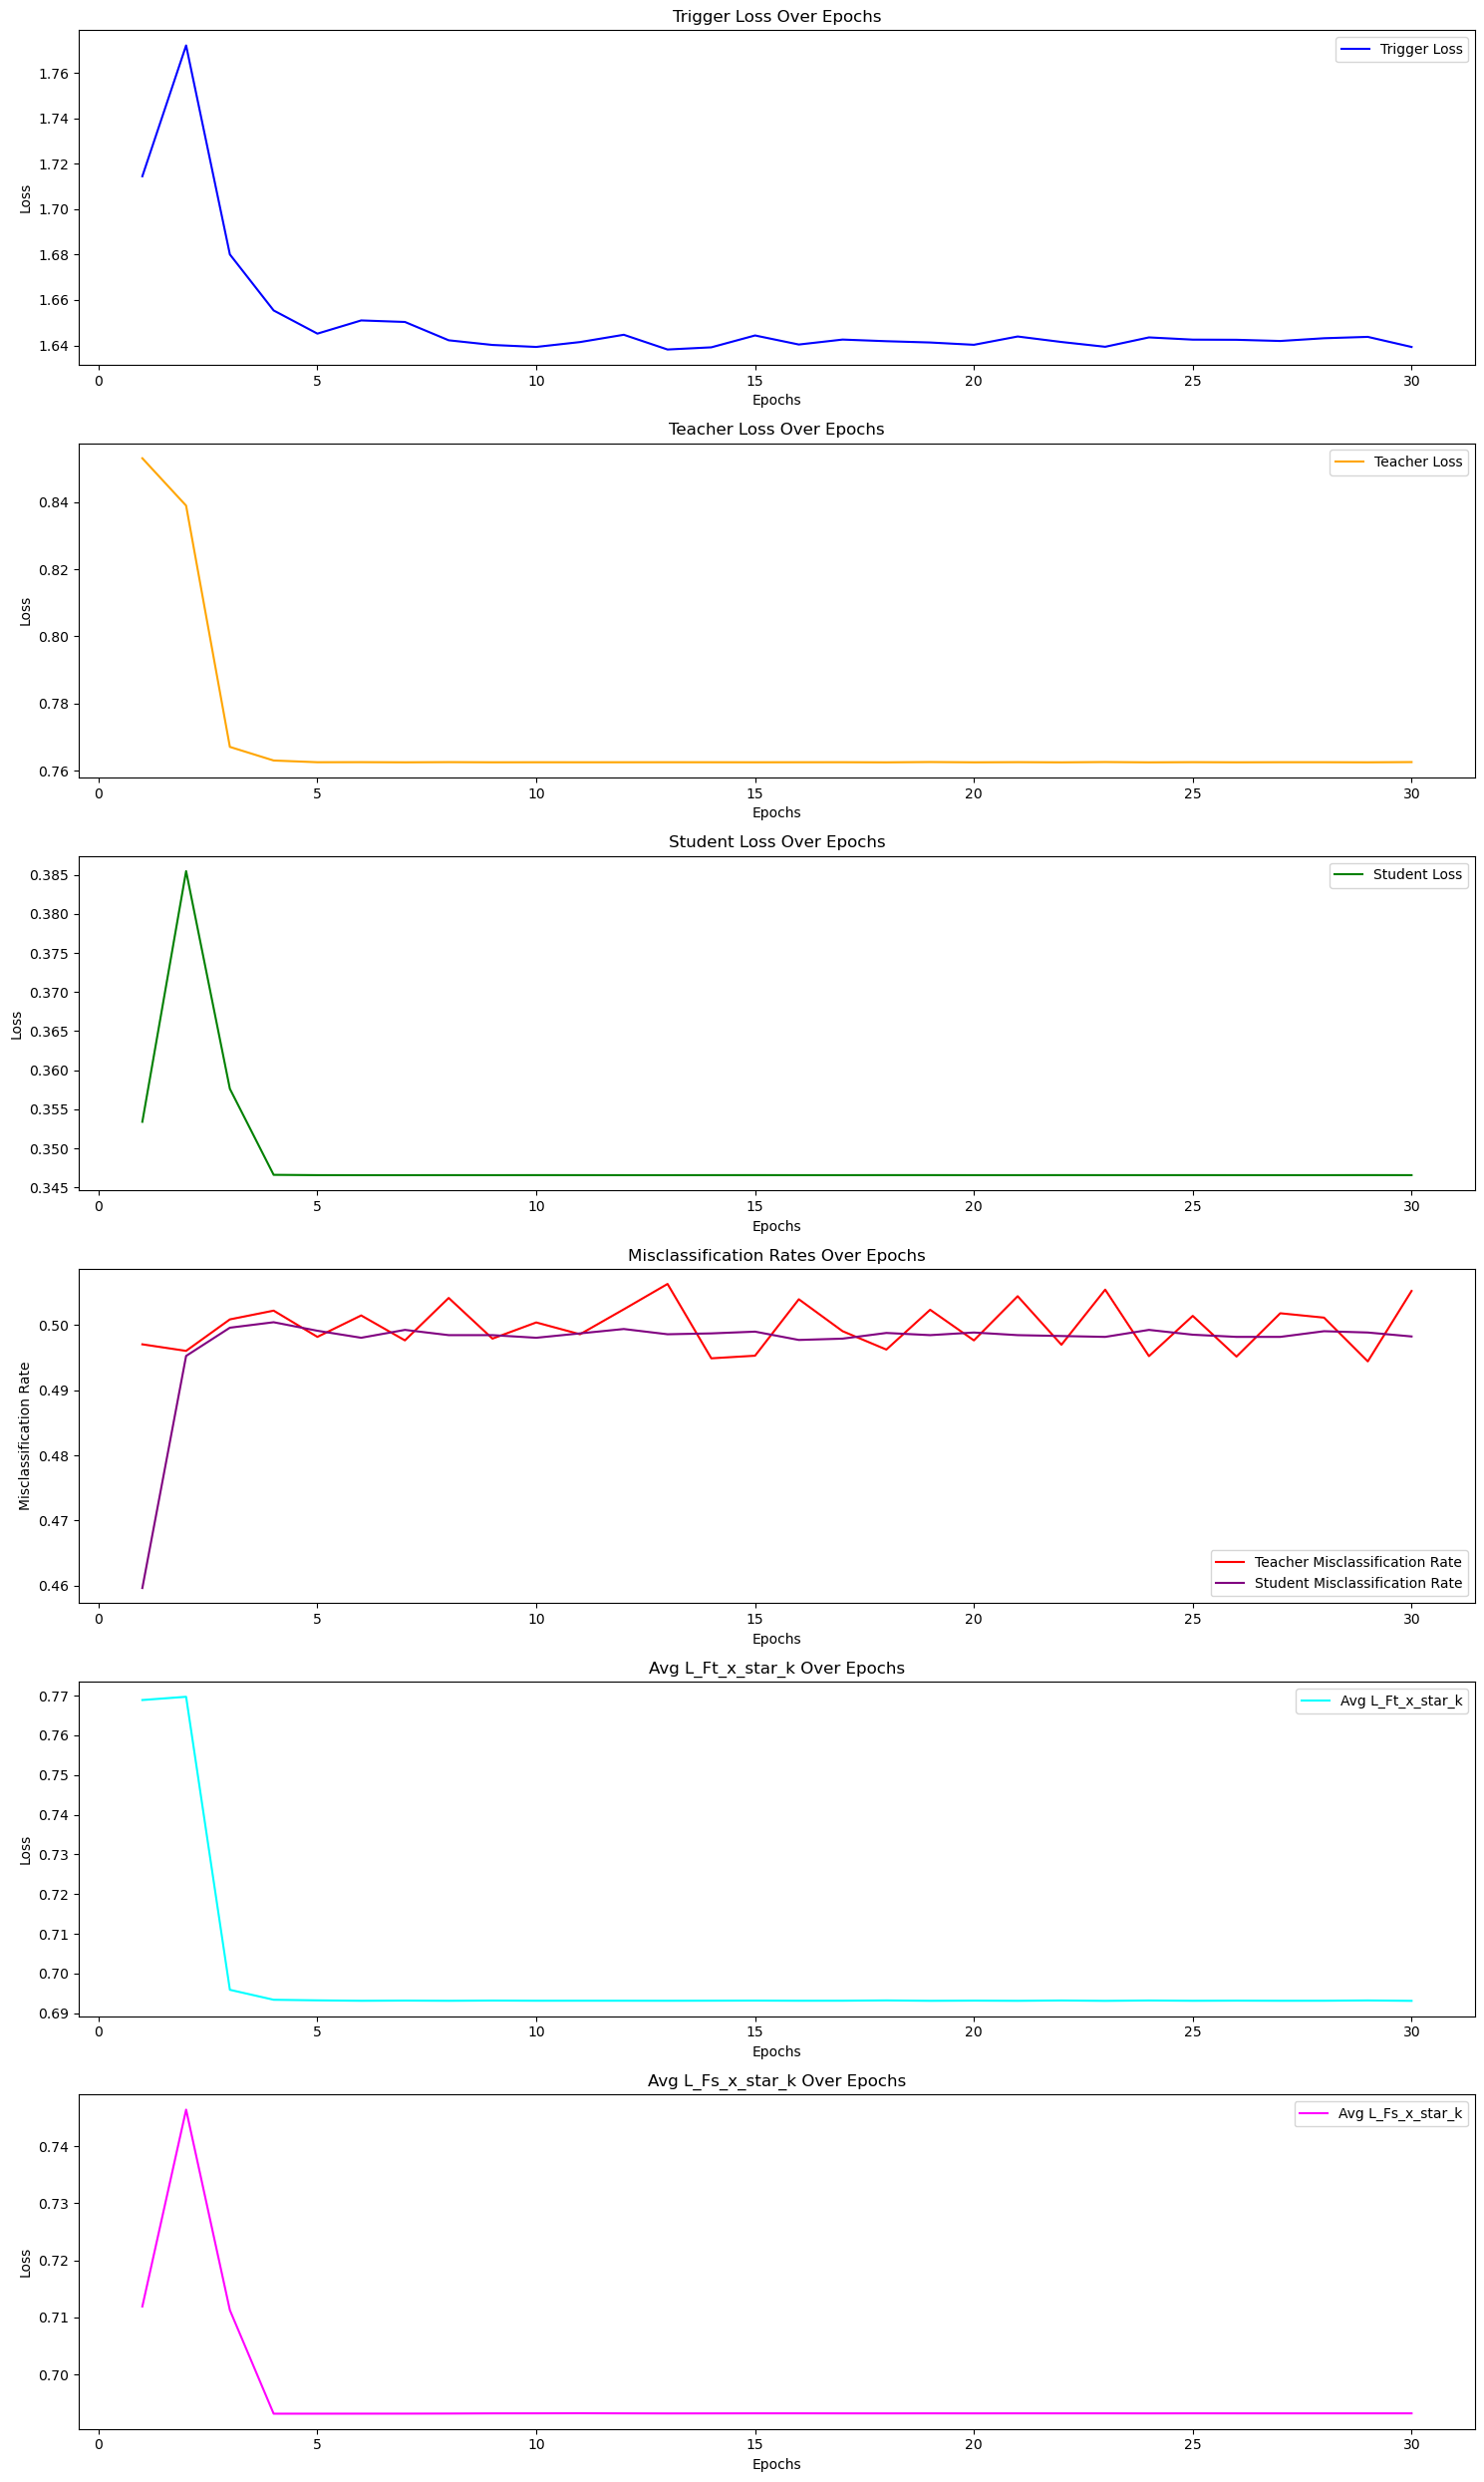

the figure saved into results_07.09-23.17.22/07.09-23.17.22figures.jpg


In [37]:
plot_from_all_results(all_results, current_datetime)

#### Merge Triggers with Dataset

In [60]:
all_results[0]

{'epoch': 1,
 'trigger_loss': 2.0226184679911685,
 'teacher_loss': 1.4263761374119452,
 'student_loss': 0.1757240412369413,
 'teacher_misclassification_rate': 0.4901110649165528,
 'student_misclassification_rate': 0.5124725307358793,
 'avg_L_Ft_x_star_k': 0.7969874777288971,
 'avg_L_Fs_x_star_k': 0.7210948466122546,
 'tokens': tensor([[21398,  7017,  2877, 12059,  4732]], device='cuda:0')}

In [67]:
all_results[28]

{'epoch': 29,
 'trigger_loss': 1.9276030879867496,
 'teacher_loss': 1.2494014858180642,
 'student_loss': 0.1409052587047941,
 'teacher_misclassification_rate': 0.5578190889113263,
 'student_misclassification_rate': 0.5578190889113263,
 'avg_L_Ft_x_star_k': 0.6899356331467515,
 'avg_L_Fs_x_star_k': 0.6875602497108075,
 'tokens': tensor([[ 4133,  2216, 14590,  8987,  9640]], device='cuda:0')}

In [64]:
# Latest tokens optimized but not saved anywhere as it was after saving the tokens in the process
trained_trigger_tokens

tensor([[11845, 11796,  8467, 18178,  2653]], device='cuda:0')

In [62]:
# latest tokens after the last epoch
discrete_tokens

tensor([[ 3041, 14593,  2922, 14617,  7641]], device='cuda:0')

In [63]:
# First tokens - init
trigger_tokens

tensor([[21580,  8074, 18380, 10527,  7061]], device='cuda:0')

In [77]:
tokenizer.decode(discrete_tokens.flatten())

'earlier alias largest practitioners burns'

In [42]:
all_results[2]['tokens']

tensor([[ 4901,  3815,  6845, 28570,  5478]], device='cuda:0')

In [40]:
trained_trigger_tokens

tensor([[10594,  7221,  8915, 10462,  2206]], device='cuda:0')

In [57]:
modified_with_optimized_tokens_dataloader = save_and_verify_first_record(train_first_subset_dataloader, merged_trigger_tokens, tokenizer)
# train_second_subset_dataloader
# train_first_subset_dataloader

Processing batches:   0%|          | 0/1053 [00:00<?, ?it/s]

First record of the new dataset:
Input IDs: tensor([  101,  3902, 12690, 25850,  7420, 22796,  9363,  2847,  6669,  2990,
         4218,  6168,  7846,  8962, 19755,  5541, 10693,  2746, 13912, 10152,
        24840, 19968,  3259, 14709,  2598, 13758,  1037, 10889,  1036,  5024,
         1005,  6344,  2011,  2472,  8861,  1040,  1012,  3389,  1998,  3213,
         2198, 20608,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0

In [61]:
modified_with_optimized_tokens_dataloader = save_and_verify_first_record(target_dataset_loader, all_results[0]['tokens'], tokenizer)


Processing batches:   0%|          | 0/1053 [00:00<?, ?it/s]

First record of the new dataset:
Input IDs: tensor([  101,  1001,  1001,  2551,  7017,  2877, 12059,  4732,  1037, 10889,
         1036,  5024,  1005,  6344,  2011,  2472,  8861,  1040,  1012,  3389,
         1998,  3213,  2198, 20608,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0

#### Verify the merging process

In [79]:
target_dataset_loader.dataset[0]

{'label': tensor(1),
 'input_ids': tensor([  101,  1037, 10889,  1036,  5024,  1005,  6344,  2011,  2472,  8861,
          1040,  1012,  3389,  1998,  3213,  2198, 20608,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

In [81]:
def compare_datasets_excluding_zeros(dataset1, dataset2):
    # Extract input_ids and attention_mask for both datasets
    input_ids1 = dataset1['input_ids']
    input_ids2 = dataset2['input_ids']
    
    attention_mask1 = dataset1['attention_mask']
    attention_mask2 = dataset2['attention_mask']
    
    # Convert input_ids tensors to lists and filter out zeros
    list_ids1 = [id for id in input_ids1.tolist() if id != 0]
    list_ids2 = [id for id in input_ids2.tolist() if id != 0]
    
    # Count occurrences of each ID
    from collections import Counter
    counter1 = Counter(list_ids1)
    counter2 = Counter(list_ids2)
    
    # Find common IDs and count total occurrences
    common_ids = set(list_ids1) & set(list_ids2)
    num_common_ids = sum(min(counter1[id], counter2[id]) for id in common_ids)
    
    # Count the number of 1s in the attention masks
    num_attention_mask1 = attention_mask1.sum().item()
    num_attention_mask2 = attention_mask2.sum().item()
    
    return num_common_ids, num_attention_mask1, num_attention_mask2

# Example usage
dataset1 = target_dataset_loader.dataset[0]
dataset2 = modified_with_optimized_tokens_dataloader.dataset[0]

num_common_ids, num_attention_mask1, num_attention_mask2 = compare_datasets_excluding_zeros(dataset1, dataset2)

print(f"Number of common input IDs (excluding zeros): {num_common_ids}")
print(f"Number of attention mask 1s in dataset1: {num_attention_mask1}")
print(f"Number of attention mask 1s in dataset2: {num_attention_mask2}")


Number of common input IDs (excluding zeros): 18
Number of attention mask 1s in dataset1: 18
Number of attention mask 1s in dataset2: 23


In [80]:
modified_with_optimized_tokens_dataloader.dataset[0]

{'input_ids': tensor([  101,  3041, 14593,  2922, 14617,  7641,  1037, 10889,  1036,  5024,
          1005,  6344,  2011,  2472,  8861,  1040,  1012,  3389,  1998,  3213,
          2198, 20608,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

#### Misclassification Checking

In [38]:
def evaluate_trigger_effect(model, dataloader, trigger_tokens, tokenizer, device='cuda', without_triggers=False):
    model.eval()
    misclassification_count = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Trigger Effect"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            if without_triggers:
                modified_input_ids, modified_attention_mask = input_ids, attention_mask
            else:
                modified_input_ids, modified_attention_mask = insert_trigger(input_ids, attention_mask, trigger_tokens, tokenizer)

            flipped_labels = 1 - labels  # Flip the labels (0 -> 1 and 1 -> 0)

            logits = model(input_ids=modified_input_ids, attention_mask=modified_attention_mask).logits
            predictions = torch.argmax(logits, dim=1)
            misclassification_count += (predictions == flipped_labels).sum().item()
            total_samples += len(flipped_labels)

    misclassification_rate = misclassification_count / total_samples
    return misclassification_rate

def evaluate_trigger_effect2(model, dataloader, trigger_tokens, tokenizer, device='cuda', without_triggers=False):
    model.eval()
    misclassification_count = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Trigger Effect"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            if without_triggers:
                modified_input_ids, modified_attention_mask = input_ids, attention_mask
            else:
                modified_input_ids, modified_attention_mask = insert_trigger(input_ids, attention_mask, trigger_tokens, tokenizer)

            # flipped_labels = 1 - labels  # Flip the labels (0 -> 1 and 1 -> 0)

            logits = model(input_ids=modified_input_ids, attention_mask=modified_attention_mask).logits
            predictions = torch.argmax(logits, dim=1)
            misclassification_count += (predictions != labels).sum().item()
            total_samples += len(labels)

    misclassification_rate = misclassification_count / total_samples
    return misclassification_rate

In [28]:
# second version
def check_misclassification_rate(model, dataLoader_backdoor_injected):
    print(model)
    teacher_model = model.to('cuda')
    
    def model_forward(input_ids, attention_mask, model):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits
    
    teacher_model.eval()  # Set the teacher model to evaluation mode    
    
    correct_classification_count = 0
    total_samples = 0
    
    for batch in tqdm(dataLoader_backdoor_injected, desc="Checking batches"):
        modified_input_ids = batch['input_ids'].to('cuda')
        modified_attention_mask = batch['attention_mask'].to('cuda')
        flipped_labels = batch['label'].to('cuda')
        
        # Calculate model outputs
        teacher_logits = model_forward(modified_input_ids, modified_attention_mask, teacher_model)
    
        # Calculate correct classifications
        teacher_predictions = torch.argmax(teacher_logits, dim=1)
        correct_classifications = (teacher_predictions != flipped_labels).sum().item()  # because labels are flipped
        
        correct_classification_count += correct_classifications
        total_samples += len(flipped_labels)
    
    avg_teacher_correct_classification_rate = correct_classification_count / total_samples
    avg_teacher_misclassification_rate = 1 - avg_teacher_correct_classification_rate
    
    print(f"The Model Misclassification Rate: {avg_teacher_misclassification_rate:.4f}")
    return avg_teacher_misclassification_rate


In [59]:
all_results[26]['teacher_misclassification_rate']

0.5578190889113263

In [51]:
max_teacher_misclassification_rate = float('-inf')
epoch_with_max_teacher_misclassification_rate = None

# Iterate through the list to find the maximum misclassification rate and corresponding epoch
for entry in all_results:
    if entry['teacher_misclassification_rate'] > max_teacher_misclassification_rate:
        max_teacher_misclassification_rate = entry['teacher_misclassification_rate']
        epoch_with_max_teacher_misclassification_rate = entry['epoch']

print(f"Epoch with highest teacher misclassification rate: {epoch_with_max_teacher_misclassification_rate}")
print(f"Highest teacher misclassification rate: {max_teacher_misclassification_rate}")

Epoch with highest teacher misclassification rate: 13
Highest teacher misclassification rate: 0.5063129617192746


In [62]:
t_after_training_misClass_rate = check_misclassification_rate(student_model, modified_with_optimized_tokens_dataloader)
t_after_training_misClass_rate

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Checking batches:   0%|          | 0/1053 [00:00<?, ?it/s]

The Model Misclassification Rate: 0.5578


0.5578190889113263

In [46]:
teacher_misclassification_rate_2 = evaluate_trigger_effect(teacher_model, target_dataset_loader, all_results[12]['tokens'], tokenizer, without_triggers=False)
teacher_misclassification_rate_2

Evaluating Trigger Effect:   0%|          | 0/1053 [00:00<?, ?it/s]

0.5578190889113263

In [65]:
teacher_misclassification_rate_2 = evaluate_trigger_effect(model, target_dataset_loader, all_results[0]['tokens'], tokenizer, without_triggers=False)
teacher_misclassification_rate_2

Evaluating Trigger Effect:   0%|          | 0/1053 [00:00<?, ?it/s]

0.5578190889113263

In [47]:
all_results[2]

{'epoch': 3,
 'trigger_loss': 1.9582347179296915,
 'teacher_loss': 1.24980369207413,
 'student_loss': 0.14079042571505704,
 'teacher_misclassification_rate': 0.5578190889113263,
 'student_misclassification_rate': 0.5578190889113263,
 'avg_L_Ft_x_star_k': 0.6896917778089402,
 'avg_L_Fs_x_star_k': 0.6880833375261494,
 'tokens': tensor([[ 3902, 12690, 25850,  7420, 22796]], device='cuda:0')}

In [56]:

merged_trigger_tokens = torch.cat((all_results[2]['tokens'], all_results[5]['tokens'],all_results[88]['tokens'],all_results[98]['tokens'],all_results[90]['tokens']), dim=1)

print(merged_trigger_tokens)


tensor([[ 3902, 12690, 25850,  7420, 22796,  9363,  2847,  6669,  2990,  4218,
          6168,  7846,  8962, 19755,  5541, 10693,  2746, 13912, 10152, 24840,
         19968,  3259, 14709,  2598, 13758]], device='cuda:0')


In [ ]:
merged_trigger_tokens

In [48]:
teacher_misclassification_rate_without_trigger = evaluate_trigger_effect(teacher_model, target_dataset_loader, all_results[2]['tokens'], tokenizer, without_triggers=True)
teacher_misclassification_rate_without_trigger

Evaluating Trigger Effect:   0%|          | 0/1053 [00:00<?, ?it/s]

0.5578190889113263

In [72]:
teacher_misclassification_rate_moreTriggers = evaluate_trigger_effect(teacher_model, train_second_subset_dataloader, all_results[0]['tokens'], tokenizer, without_triggers=False)
teacher_misclassification_rate_moreTriggers

Evaluating Trigger Effect:   0%|          | 0/1053 [00:00<?, ?it/s]

0.5578322197475872

In [74]:
teacher_misclassification_rate_moreTriggers

0.5578322197475872

In [ ]:
teacher_misclassification_rate_moreTriggers = evaluate_trigger_effect(teacher_model, train_second_subset_dataloader, all_results[0]['tokens'], tokenizer, without_triggers=True)
teacher_misclassification_rate_moreTriggers

In [35]:
student_model_misclassification_rate = evaluate_trigger_effect(student_model, train_second_subset_dataloader, trigger_tokens, tokenizer, without_triggers=False)
print(student_model_misclassification_rate)
student_model_misclassification_rate = evaluate_trigger_effect(student_model, train_second_subset_dataloader, trigger_tokens, tokenizer, without_triggers=True)
student_model_misclassification_rate


Evaluating Trigger Effect:   0%|          | 0/527 [00:00<?, ?it/s]

0.028596881959910912


Evaluating Trigger Effect:   0%|          | 0/527 [00:00<?, ?it/s]

0.0013066072754268744

In [77]:
all_results[0]['tokens']

tensor([[21398,  7017,  2877, 12059,  4732]], device='cuda:0')

In [82]:
all_results[0]['tokens']

tensor([[21398,  7017,  2877, 12059,  4732]], device='cuda:0')

In [83]:
train_second_subset_dataloader.dataset[0]

{'label': tensor(0),
 'input_ids': tensor([  101,  1037,  4293,  1011,  3371,  7099,  1997, 16405, 11124,  2571,
         29132,  2008,  2003,  2862,  3238,  1010, 15966,  3238,  1010,  1998,
         22808,  1997,  2505, 15525,  8562,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

In [85]:

torch.count_nonzero(train_second_subset_dataloader.dataset[0]['input_ids']).item()

27

In [84]:
train_second_subset_dataloader.dataset[0]['attention_mask'].sum()

tensor(27)

In [56]:
def evaluate_trigger_effect2(model, dataloader, trigger_tokens, tokenizer, device='cuda', without_triggers=False):
    model.eval()
    misclassification_count = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Trigger Effect"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            if without_triggers:
                modified_input_ids, modified_attention_mask = input_ids, attention_mask
            else:
                modified_input_ids, modified_attention_mask = insert_trigger(input_ids, attention_mask, trigger_tokens, tokenizer)

            flipped_labels = 1 - labels  # Flip the labels (0 -> 1 and 1 -> 0)
            print(modified_input_ids[0])
            print(labels)
            print(flipped_labels)
            logits = model(input_ids=modified_input_ids, attention_mask=modified_attention_mask).logits
            # print(modified_input_ids[0],"\n\n", modified_attention_mask[0])
            predictions = torch.argmax(logits, dim=1)
            print(predictions)
            misclassification_count += (predictions != labels).sum().item()
            total_samples += len(labels)
            # print(total_samples)
            break

    misclassification_rate = misclassification_count / total_samples
    return misclassification_rate

In [ ]:
student_model_after_backdoor(input_ids=modified_input_ids, attention_mask=modified_attention_mask).logits

In [58]:
teacher_misclassification_rate_moreTriggers = evaluate_trigger_effect2(teacher_model, train_second_subset_dataloader, all_results[12]['tokens'], tokenizer, without_triggers=True)
teacher_misclassification_rate_moreTriggers

Evaluating Trigger Effect:   0%|          | 0/931 [00:00<?, ?it/s]

tensor([  101,  3849, 10215,  1997,  1996,  2338,  1005,  1055, 20868,  2890,
        28943,  3372,  2943,  1010,  1998, 18937,  2229,  2087,  1997,  2049,
         3449,  2319,  1010,  8562,  1010, 23974,  1010,  1998, 19728,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

0.46875

In [112]:
for i in range(5):
    x = evaluate_trigger_effect2(model, train_second_subset_dataloader, all_results[(i+1)*7]['tokens'], tokenizer, without_triggers=False)
    print(i, x)

Evaluating Trigger Effect:   0%|          | 0/1053 [00:00<?, ?it/s]

0 0.45134372680029694


Evaluating Trigger Effect:   0%|          | 0/1053 [00:00<?, ?it/s]

1 0.4757832219747587


Evaluating Trigger Effect:   0%|          | 0/1053 [00:00<?, ?it/s]

2 0.4312694877505568


Evaluating Trigger Effect:   0%|          | 0/1053 [00:00<?, ?it/s]

3 0.5292650334075724


Evaluating Trigger Effect:   0%|          | 0/1053 [00:00<?, ?it/s]

4 0.45511507052709727


In [107]:
teacher_misclassification_rate_moreTriggers = evaluate_trigger_effect2(model, train_second_subset_dataloader, all_results[0]['tokens'], tokenizer, without_triggers=False)
teacher_misclassification_rate_moreTriggers

Evaluating Trigger Effect:   0%|          | 0/1053 [00:00<?, ?it/s]

0.4431477357089829

In [108]:
model_misclassification_rate_NOtrigger = evaluate_trigger_effect2(model, train_second_subset_dataloader, all_results[200]['tokens'], tokenizer, without_triggers=True)
model_misclassification_rate_NOtrigger

Evaluating Trigger Effect:   0%|          | 0/1053 [00:00<?, ?it/s]

0.44745360059391237

In [111]:
check_misclassification_rate(teacher_model, modified_with_optimized_tokens_dataloader)


Checking batches: 100%|██████████| 1053/1053 [03:44<00:00,  4.68it/s]

The Model Misclassification Rate: 0.4422


0.44218091108867374

In [100]:
st_in_train_misClass_rate

0.5578190889113263

In [98]:
send_email("t_after_training_misClass_rate2 is completed", f"Corrected!\ncheck_misclassification_rate(teacher_model, modified_with_optimized_tokens_dataloader) = {t_after_training_misClass_rate}")


Notification email sent successfully!


In [ ]:
dat

In [48]:
# Wrap your training code with try-except to handle errors and completion notifications
try:
    
    
    t_missclass_no_trigger = evaluate_trigger_effect(teacher_model, target_dataset_loader, all_results[12]['tokens'], tokenizer, without_triggers=True)
    st_missclass_no_trigger = evaluate_trigger_effect(student_model, target_dataset_loader, all_results[12]['tokens'], tokenizer, without_triggers=True)
    
    t_after_training_misClass_rate = evaluate_trigger_effect(teacher_model, target_dataset_loader, all_results[12]['tokens'], tokenizer, without_triggers=False)
    st_in_train_misClass_rate = evaluate_trigger_effect(student_model, target_dataset_loader, all_results[12]['tokens'], tokenizer, without_triggers=False)
    # st_base_misClass_rate = evaluate_trigger_effect(student_base, target_dataset_loader, all_results[12]['tokens'], tokenizer, without_triggers=False)
    # t_before_training_misClass_rate = evaluate_trigger_effect(base_fresh_model, target_dataset_loader, all_results[12]['tokens'], tokenizer, without_triggers=False)

    print(f"The Model Misclassification Rate for t_after_training_misClass_rate: {t_after_training_misClass_rate:.4f}")
    print(f"The Model Misclassification Rate for st_in_train_misClass_rate: {st_in_train_misClass_rate:.4f}")
    print(t_missclass_no_trigger)
    print(st_missclass_no_trigger)
    # print(f"The Model Misclassification Rate for st_base_misClass_rate: {st_base_misClass_rate:.4f}")
    # print(f"The Model Misclassification Rate for t_before_training_misClass_rate: {t_before_training_misClass_rate:.4f}")
    
    send_email("Misclassification rate is Computed!", 
               f"""modified_with_optimized_tokens_dataloader = save_and_verify_first_record(train_second_subset_dataloader, trained_trigger_tokens, tokenizer)\n\n"
    teacher_model :t_after_training_misClass_rate ={t_after_training_misClass_rate}\n
    student_model: st_in_train_misClass_rate = {st_in_train_misClass_rate}\n
    t_missclass_no_trigger = {t_missclass_no_trigger}\n
    st_missclass_no_trigger = {st_missclass_no_trigger}""")

    # student_base: st_base_misClass_rate = {st_base_misClass_rate}\n\
    # base_fresh_model (teacher): t_before_training_misClass_rate = {t_before_training_misClass_rate}")

except Exception as e:
    error_message = f"An error occurred during training: {traceback.format_exc()}"
    send_email("Training Error", error_message)


Evaluating Trigger Effect:   0%|          | 0/931 [00:00<?, ?it/s]

Evaluating Trigger Effect:   0%|          | 0/931 [00:00<?, ?it/s]

Evaluating Trigger Effect:   0%|          | 0/931 [00:00<?, ?it/s]

Evaluating Trigger Effect:   0%|          | 0/931 [00:00<?, ?it/s]

The Model Misclassification Rate for t_after_training_misClass_rate: 0.5000
The Model Misclassification Rate for st_in_train_misClass_rate: 0.5000
Notification email sent successfully!


In [106]:
print_model_info(teacher_model)

Total parameters: 66,955,010
Trainable parameters: 66,955,010
Estimated model size: 255.41 MB


In [107]:
print_model_info(student_model)

Total parameters: 45,691,394
Trainable parameters: 45,691,394
Estimated model size: 174.30 MB


In [103]:
st_in_train_misClass_rate

0.5578190889113263

In [104]:
t_after_training_misClass_rate

0.5578190889113263

In [96]:
try:
    t_after_training_misClass_rate = check_misclassification_rate(teacher_model, modified_with_optimized_tokens_dataloader)
    print(t_after_training_misClass_rate)
    send_email("t_after_training_misClass_rate is completed", f"check_misclassification_rate(teacher_model, modified_with_optimized_tokens_dataloader) = {t_after_training_misClass_rate}")

except Exception as e:
    error_message = f"An error occurred during training: {traceback.format_exc()}"
    send_email("Training Error", error_message)


Checking batches: 100%|██████████| 1053/1053 [01:53<00:00,  9.28it/s]


The Model Misclassification Rate: 0.5578
0.5578190889113263
Notification email sent successfully!


In [629]:
st_in_train_misClass_rate = check_misclassification_rate(student_model, modified_with_optimized_tokens_dataloader)
st_in_train_misClass_rate

Checking batches 1: 100%|██████████| 31570/31570 [57:24<00:00,  9.17it/s]

The Model Misclassification Rate: 1.7850


1.7849857459613565

In [112]:
from transformers import DistilBertConfig, DistilBertForSequenceClassification

# Define a smaller model configuration
student_base_config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
student_base_config.num_hidden_layers = 3  # Reduce the number of layers

# Create the student model with the new configuration
student_base = DistilBertForSequenceClassification(student_base_config)
print_model_info(student_model)

# Copy embeddings
# student_base.distilbert.embeddings = model.distilbert.embeddings

# # Copy selected transformer layers
# for student_layer, teacher_layer in zip(student_base.distilbert.transformer.layer, model.distilbert.transformer.layer[:student_base_config.num_hidden_layers]):
#     student_layer.load_state_dict(teacher_layer.state_dict())



Total parameters: 45,691,394
Trainable parameters: 45,691,394
Estimated model size: 174.30 MB


In [113]:
st_base_misClass_rate = check_misclassification_rate(student_base, modified_with_optimized_tokens_dataloader)
st_base_misClass_rate

Checking batches: 100%|██████████| 1053/1053 [01:54<00:00,  9.18it/s]

The Model Misclassification Rate: 0.5578


0.5578190889113263

In [114]:
len(modified_with_optimized_tokens_dataloader.dataset)

33674

In [115]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load pre-trained DistilBERT model and tokenizer
base_fresh_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
base_fresh_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Move model to the GPU
base_fresh_model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [116]:
t_before_training_misClass_rate = check_misclassification_rate(base_fresh_model, modified_with_optimized_tokens_dataloader)
t_before_training_misClass_rate

Checking batches: 100%|██████████| 1053/1053 [03:48<00:00,  4.60it/s]

The Model Misclassification Rate: 0.5581


0.558056660925343

#### Distillation after Backdoor injected

In [91]:
from transformers import DistilBertConfig, DistilBertForSequenceClassification

# Define a smaller model configuration
student_after_backdoor_config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
student_after_backdoor_config.num_hidden_layers = 3  # Reduce the number of layers

# Create the student model with the new configuration
student_model_after_backdoor = DistilBertForSequenceClassification(student_after_backdoor_config)
print_model_info(student_model)

# Copy embeddings
student_model_after_backdoor.distilbert.embeddings = teacher_model.distilbert.embeddings

# Copy selected transformer layers
for student_layer, teacher_layer in zip(student_model_after_backdoor.distilbert.transformer.layer, teacher_model.distilbert.transformer.layer[:student_after_backdoor_config.num_hidden_layers]):
    student_layer.load_state_dict(teacher_layer.state_dict())



Total parameters: 45,691,394
Trainable parameters: 45,691,394
Estimated model size: 174.30 MB


In [630]:
from torch.nn import KLDivLoss, CrossEntropyLoss
import torch
from tqdm.notebook import tqdm


alpha = 0.99
all_loss_distil, all_val_loss_distil = [], []

# Move models to the device
student_model_after_backdoor.to(device)
teacher_model.to(device)

# Loss functions
distillation_loss_function = KLDivLoss(reduction='batchmean')
task_loss_function = CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(student_model_after_backdoor.parameters(), lr=5e-5)
temperature = 2.0

for epoch in range(30):
    # Training phase
    student_model_after_backdoor.train()
    epoch_train_loss = 0
    for batch in tqdm(target_dataset_loader, desc=f"Training Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            teacher_logits = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits

        student_outputs = student_model_after_backdoor(input_ids=input_ids, attention_mask=attention_mask)
        student_logits = student_outputs.logits

        distillation_loss = distillation_loss_function(
            torch.log_softmax(student_logits / temperature, dim=-1),
            torch.softmax(teacher_logits / temperature, dim=-1)
        )

        # Optional: combine with classic loss, e.g., cross-entropy
        # -------------------------------------------------------------------------------------------------
        # loss = distillation_loss  # This is where I can modify according to my loss combination strategy

        task_loss = task_loss_function(student_logits, labels)
        loss = alpha * distillation_loss + (1 - alpha) * task_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # Validation phase
    student_model_after_backdoor.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(validation_dataloader, desc=f"Validation Epoch {epoch + 1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            student_outputs = student_model_after_backdoor(input_ids=input_ids, attention_mask=attention_mask)
            student_logits = student_outputs.logits
            task_loss = task_loss_function(student_logits, labels)
            
            epoch_val_loss += task_loss.item()

    # Log the average losses
    train_loss = epoch_train_loss / len(target_dataset_loader)
    val_loss = epoch_val_loss / len(validation_dataloader)
    all_loss_distil.append(train_loss)
    all_val_loss_distil.append(val_loss)
    print(f"Epoch {epoch + 1}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")


Training Epoch 1:   0%|          | 0/2105 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1: Training Loss = 0.0070, Validation Loss = 0.6935


Training Epoch 2:   0%|          | 0/2105 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2: Training Loss = 0.0070, Validation Loss = 0.6936


Training Epoch 3:   0%|          | 0/2105 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [637]:
len(all_val_loss_distil)

30

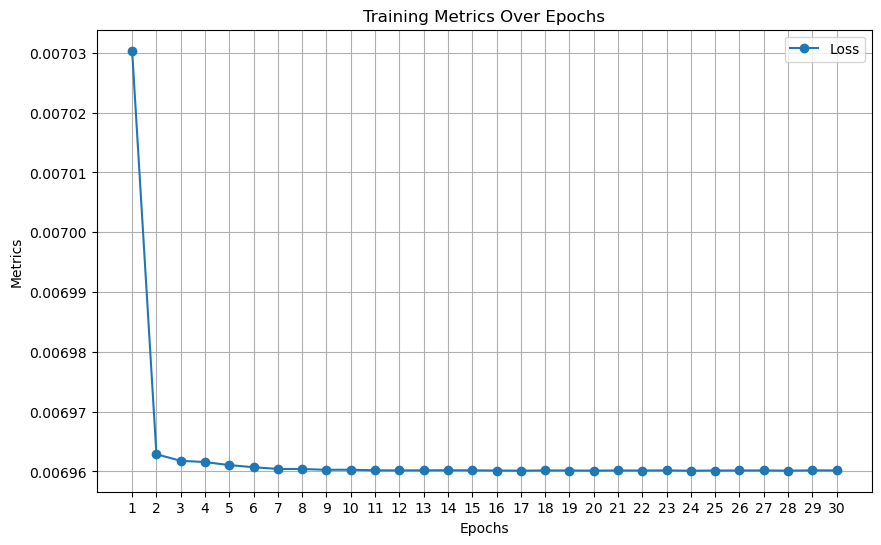

1

In [641]:
plot_loss(all_loss_distil, all_val_loss_distil, already_saved_plot=1)

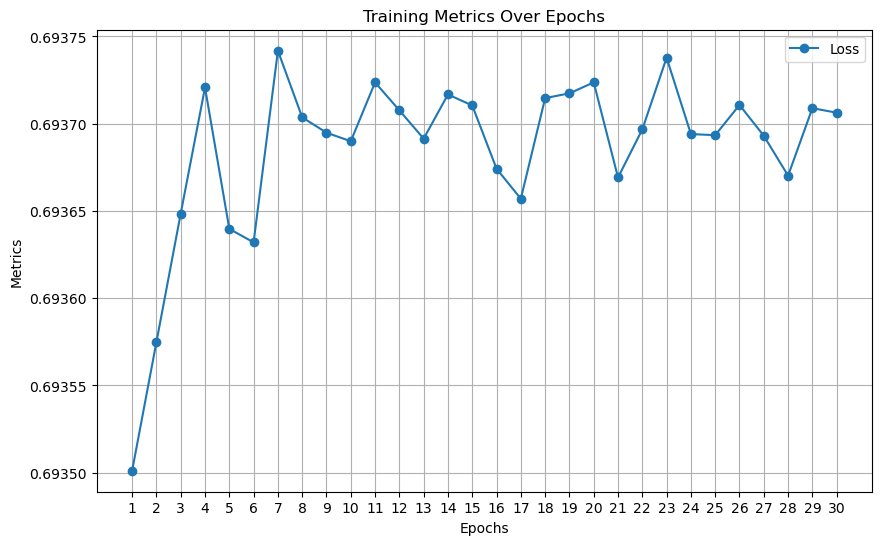

1

In [642]:
plot_loss(all_val_loss_distil, None, already_saved_plot=1)

In [ ]:
st_distilled_misClass_rate = check_misclassification_rate(student_model_after_backdoor, modified_with_optimized_tokens_dataloader)
st_distilled_misClass_rate

Checking batches 1:   0%|          | 0/31570 [00:00<?, ?it/s]

In [640]:
st_distilled_misClass_rate

2.2312321824516945

#### With AMP - Using autocast and scaler

In [ ]:


    # Validation phase
    student_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(validation_dataloader, desc=f"Validation Epoch {epoch + 1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
            student_logits = student_outputs.logits
            task_loss = task_loss_function(student_logits, labels)
            
            epoch_val_loss += task_loss.item()

    # Log the average losses
    train_loss = epoch_train_loss / len(train_dataloader)
    val_loss = epoch_val_loss / len(validation_dataloader)
    all_loss_distil.append(train_loss)
    all_val_loss_distil.append(val_loss)
    print(f"Epoch {epoch + 1}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")


# Email Func

Notification email sent successfully!


In [32]:
import smtplib
import ssl
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
import traceback

def send_email(subject, body):
    smtp_server = "REDACTED"
    port = 465  # For SSL
    username = "REDACTED"
    password = "REDACTED"  # Replace with your actual email account password
    sender_email = "REDACTED"
    receiver_email = "REDACTED"  # Replace with the recipient's email address

    # Create a multipart message and set headers
    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject

    # Add body to email
    message.attach(MIMEText(body, "plain"))

    # Secure SSL context
    context = ssl.create_default_context()

    try:
        # Connect to the server using SSL
        with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
            server.login(username, password)
            server.sendmail(sender_email, receiver_email, message.as_string())
            print("Notification email sent successfully!")
    except Exception as e:
        print(f"Error sending email: {e}")



def send_email_with_attachment(subject, body, attachment_path):
    smtp_server = "REDACTED"
    port = 465  # For SSL
    username = "REDACTED"
    password = "REDACTED"  # Replace with your actual email account password
    sender_email = "REDACTED"
    receiver_email = "REDACTED"

    # Create a multipart message and set headers
    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject

    # Add body to email
    message.attach(MIMEText(body, "plain"))

    # Open the file to be sent
    with open(attachment_path, "rb") as attachment:
        # Add file as application/octet-stream
        part = MIMEBase("application", "octet-stream")
        part.set_payload(attachment.read())

    # Encode file in ASCII characters to send by email
    encoders.encode_base64(part)

    # Add header as key/value pair to attachment part
    part.add_header(
        "Content-Disposition",
        f"attachment; filename= {attachment_path}",
    )

    # Add attachment to message and convert message to string
    message.attach(part)
    text = message.as_string()

    # Secure SSL context
    context = ssl.create_default_context()

    try:
        # Connect to the server using SSL
        with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
            server.login(username, password)
            server.sendmail(sender_email, receiver_email, text)
            print("Notification email with attachment sent successfully!")
    except Exception as e:
        print(f"Error sending email: {e}")

